## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
#!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to set a graph theme in seaborn
sns.set_theme(style="darkgrid",  palette="husl")

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Learning/PGPDSBA/Project-6/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Learning/PGPDSBA/Project-6/Test.csv')

In [4]:
# let's create a copy of the training data
data = df.copy()

In [5]:
# let's create a copy of the training data
data_test = df_test.copy()

## Data Overview

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [ ]:
# Checking the number of rows and columns in the training data
data.shape

(20000, 41)

In [ ]:
# Checking the number of rows and columns in the test data
df_test.shape

(5000, 41)

### Displaying the first few rows of the dataset

In [ ]:
# let's view the first 5 rows of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
# let's view the last 5 rows of the data
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


### Checking the data types of the columns for the dataset

In [ ]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

### Checking for duplicate values

In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum()

np.int64(0)

### Checking for missing values

In [ ]:
# let's check for missing values in the data
data.isnull().sum()

,0
V1,18
V2,18
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [ ]:
# let's check for missing values in the data
data_test.isnull().sum()

,0
V1,5
V2,6
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


### Statistical summary of the dataset

In [ ]:
# let's view the statistical summary of the numerical columns in the training data
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


#### Summary from Data Overview

* There are 20000 rows in the training set and 5000 rows in the testing set

* There are 41 columns in both training and testing sets

* All of the feature columns are float data types and the target is an integer.

* The training set has 36 missing values (columns v1 and v2) and no duplicates

* The testing set has 11 missing values (columns v1 and v2) and no duplicates


Since the feature columns are specific measurments from various sensors, there is nothing much to infer at this point. Lets proceed to EDA.

## Exploratory Data Analysis

### Univariate analysis

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

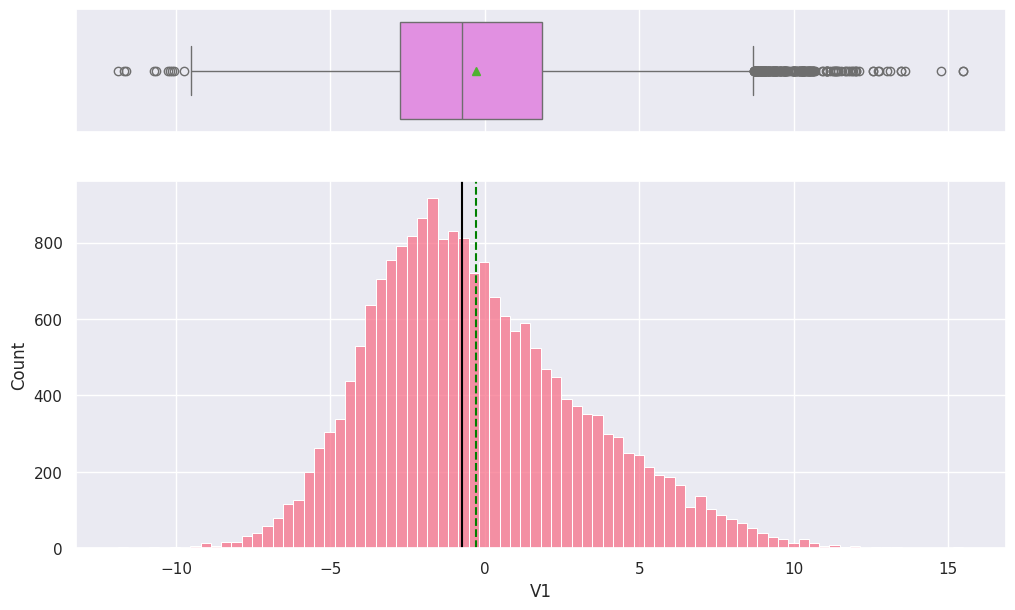

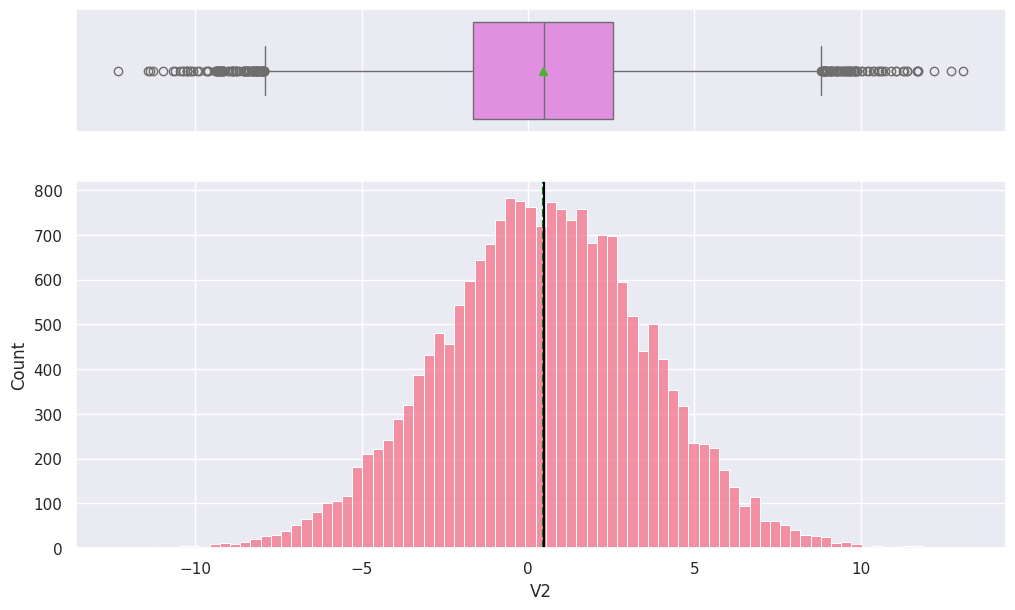

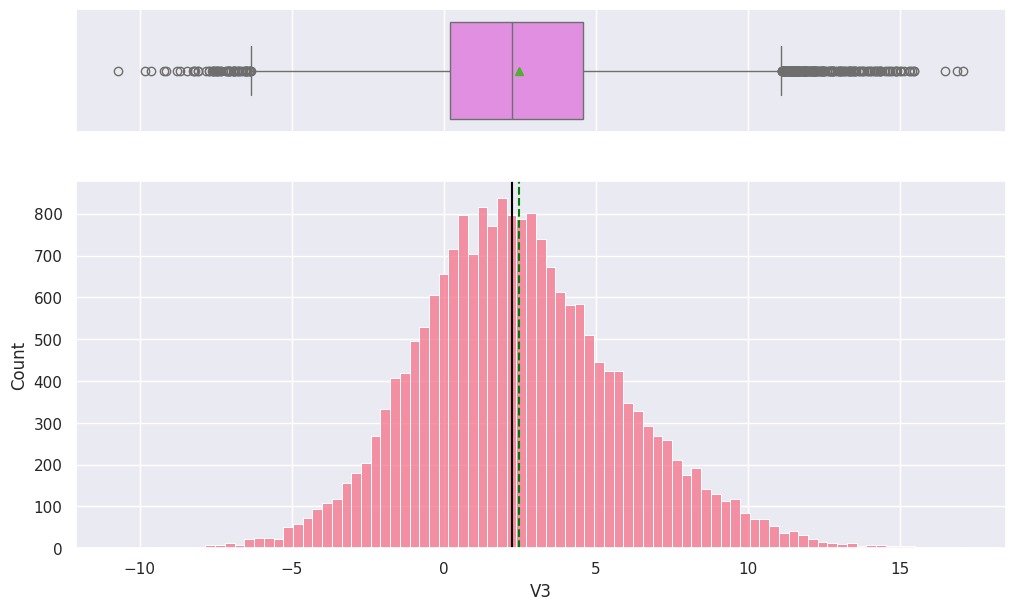

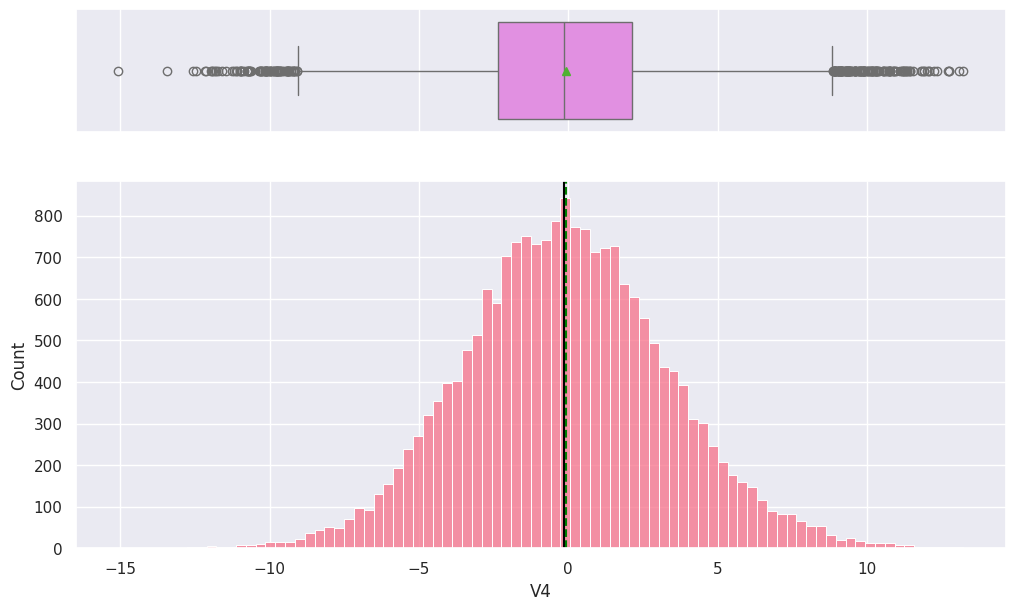

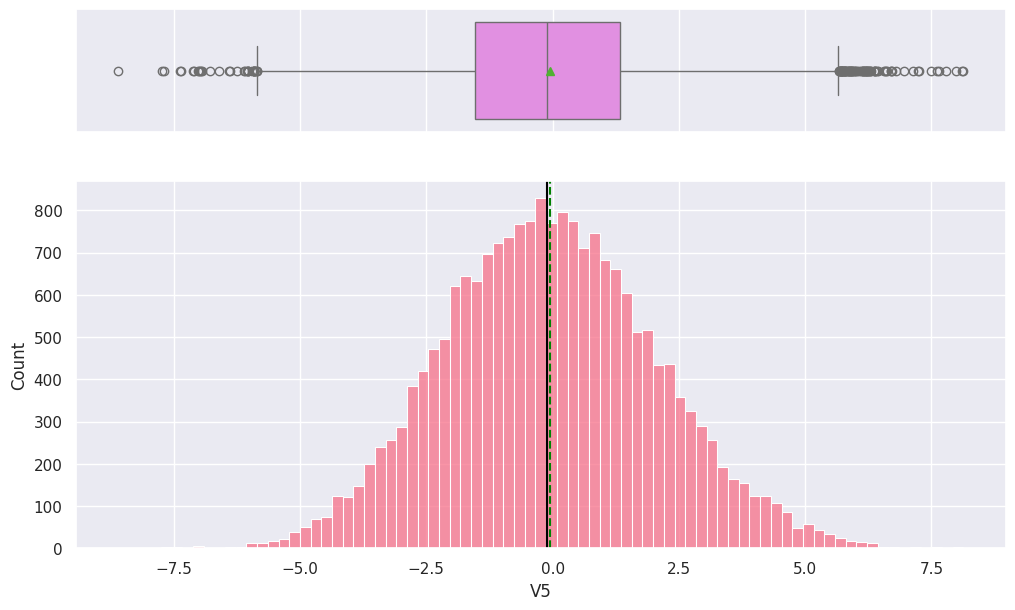

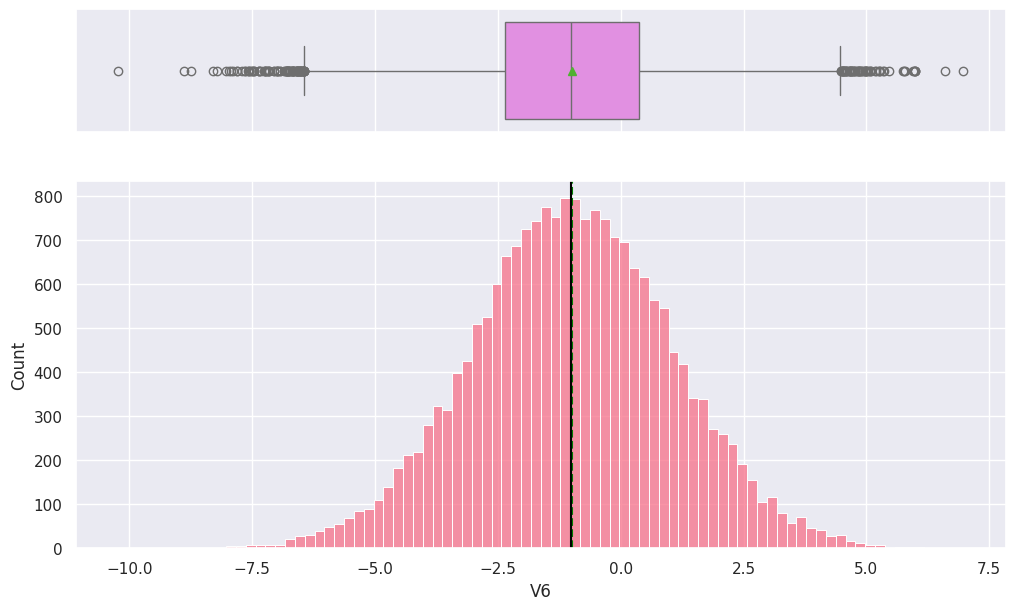

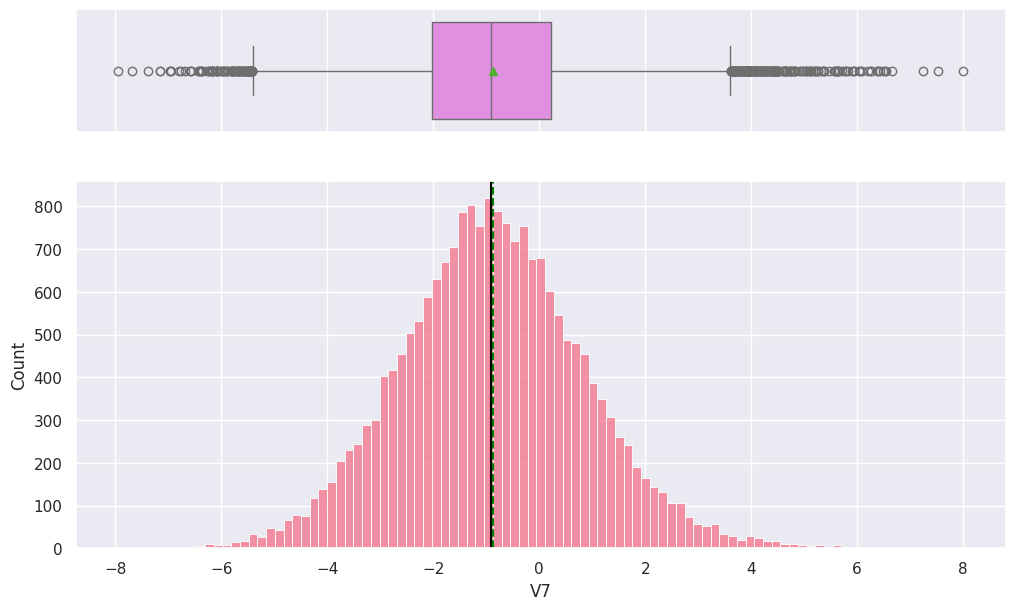

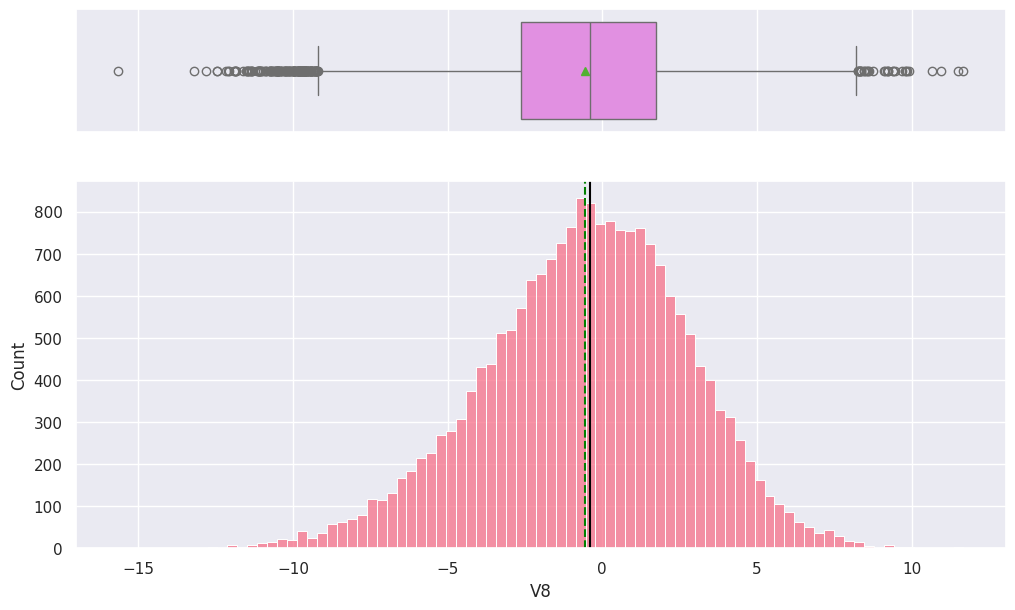

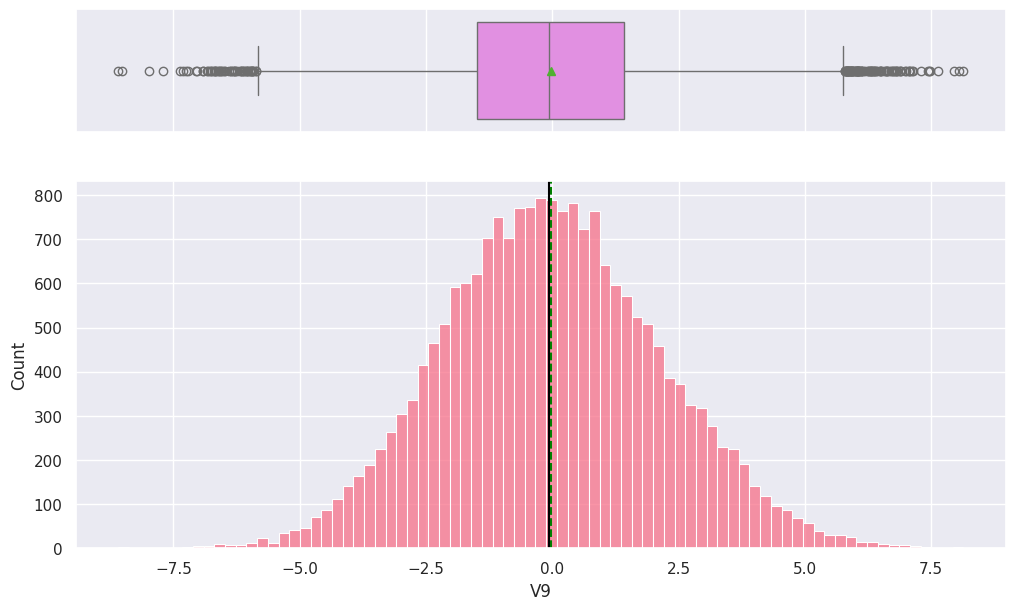

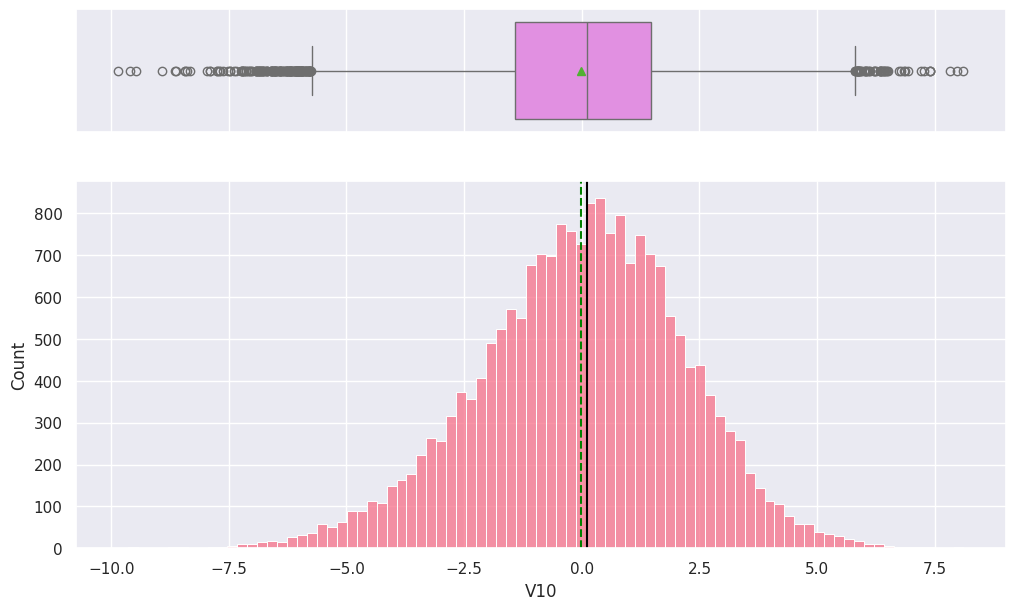

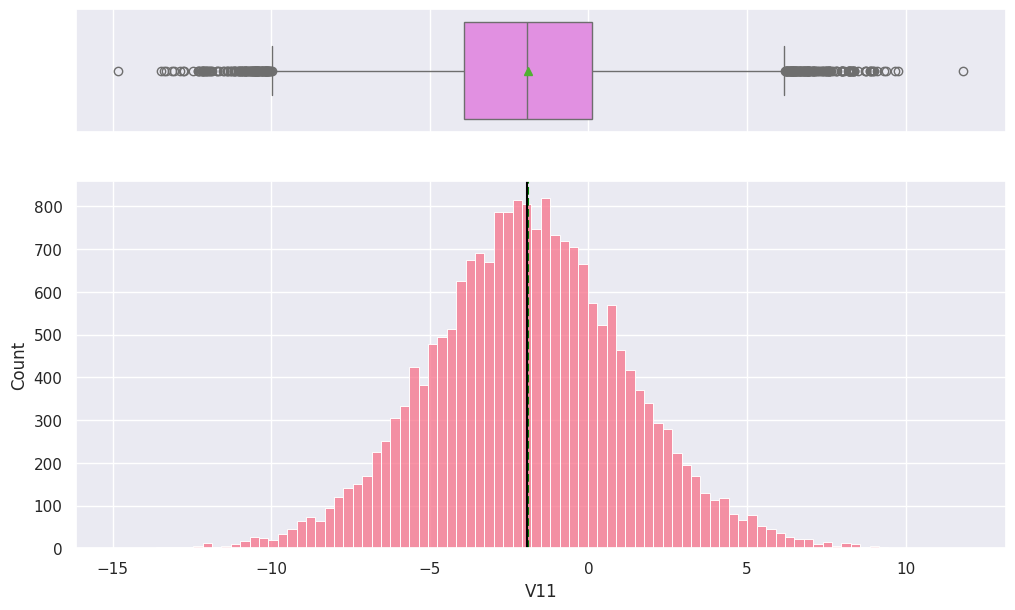

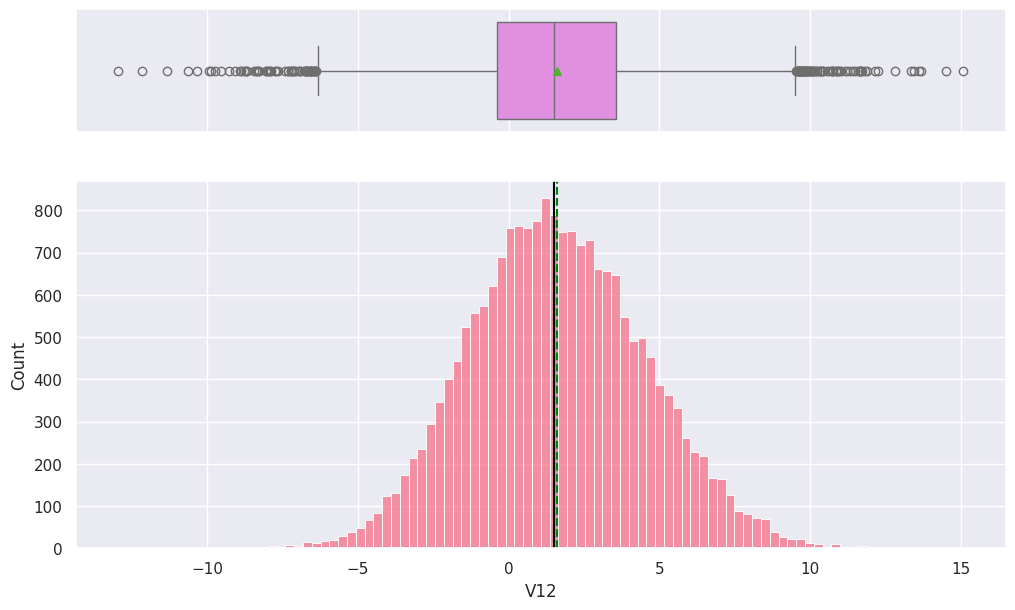

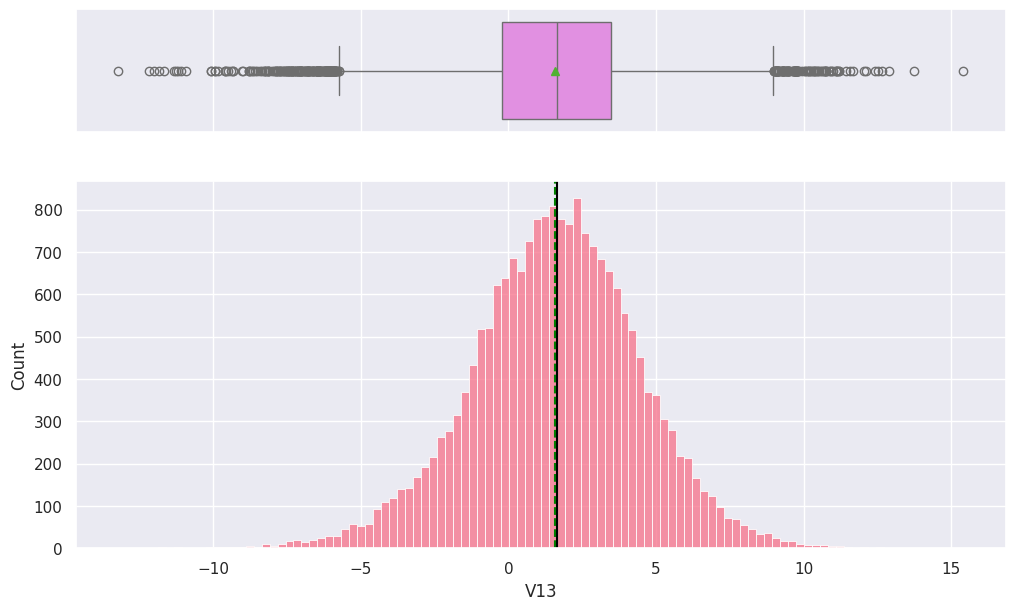

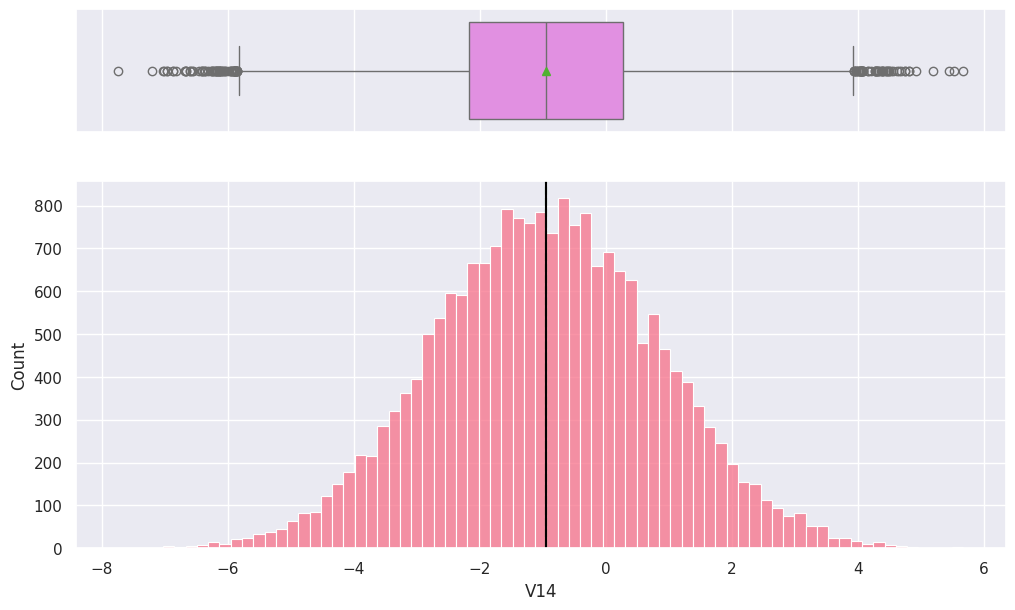

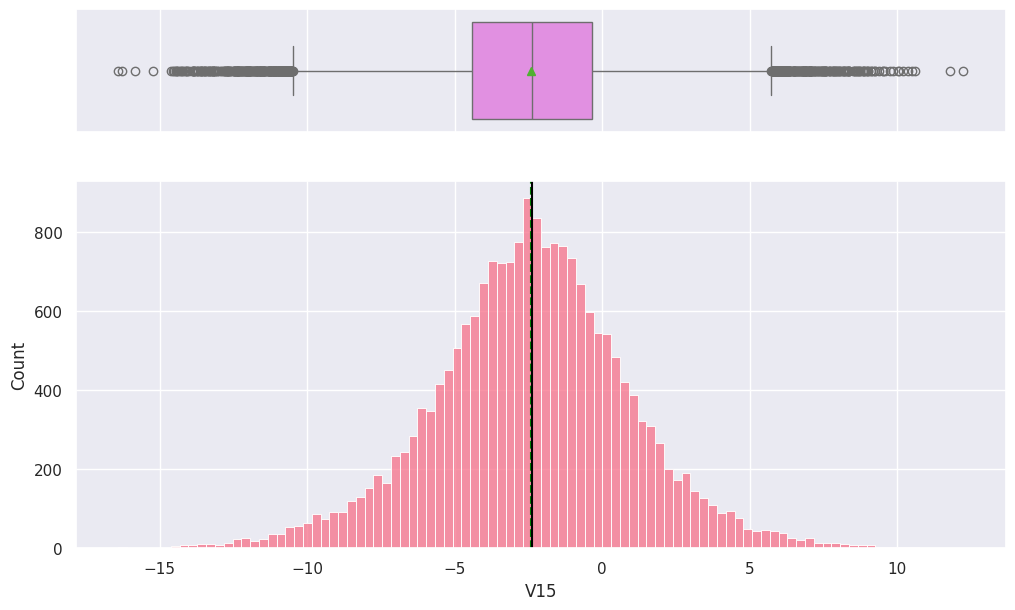

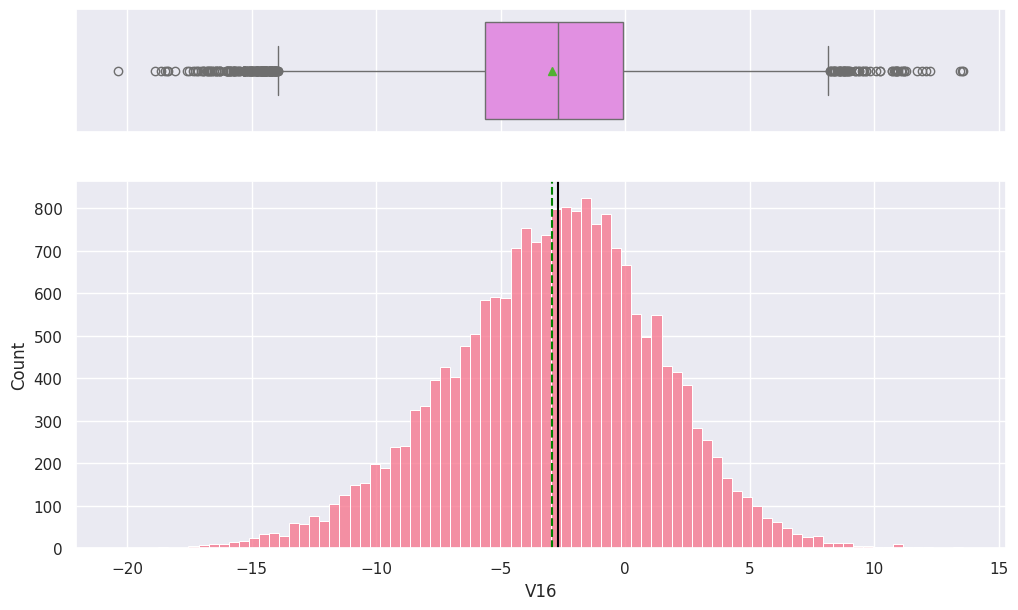

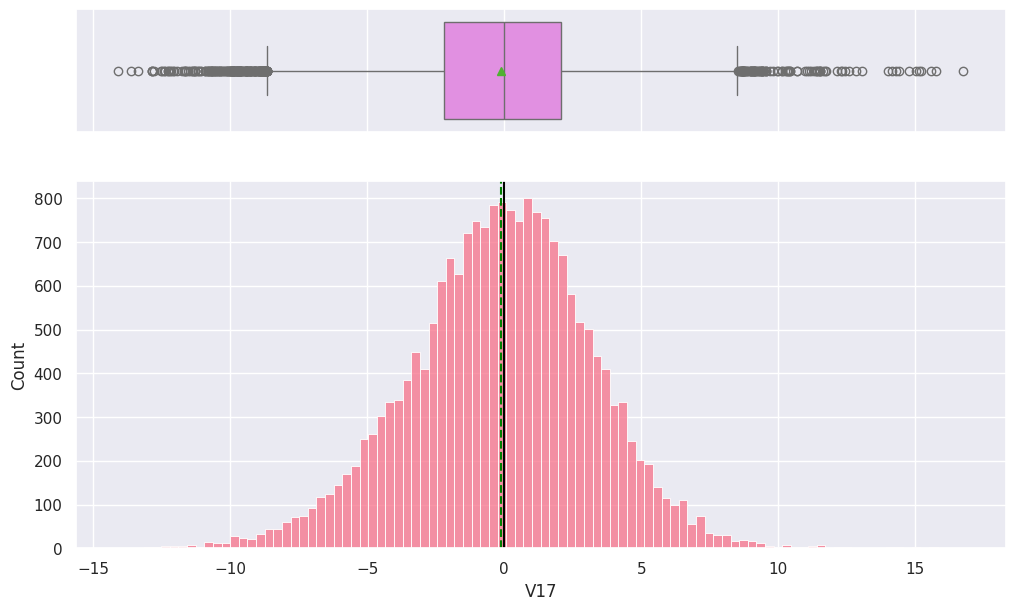

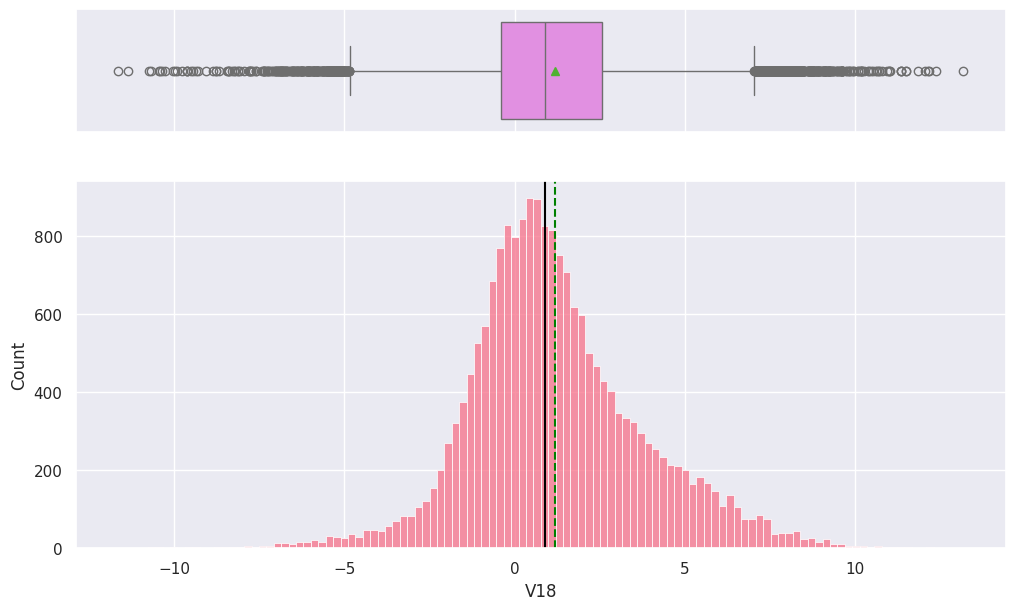

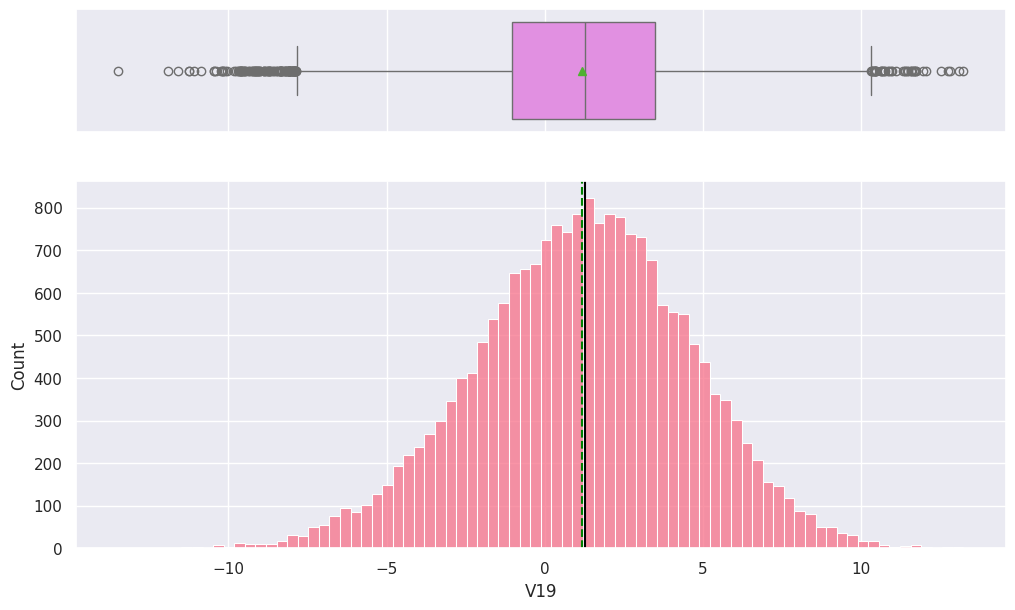

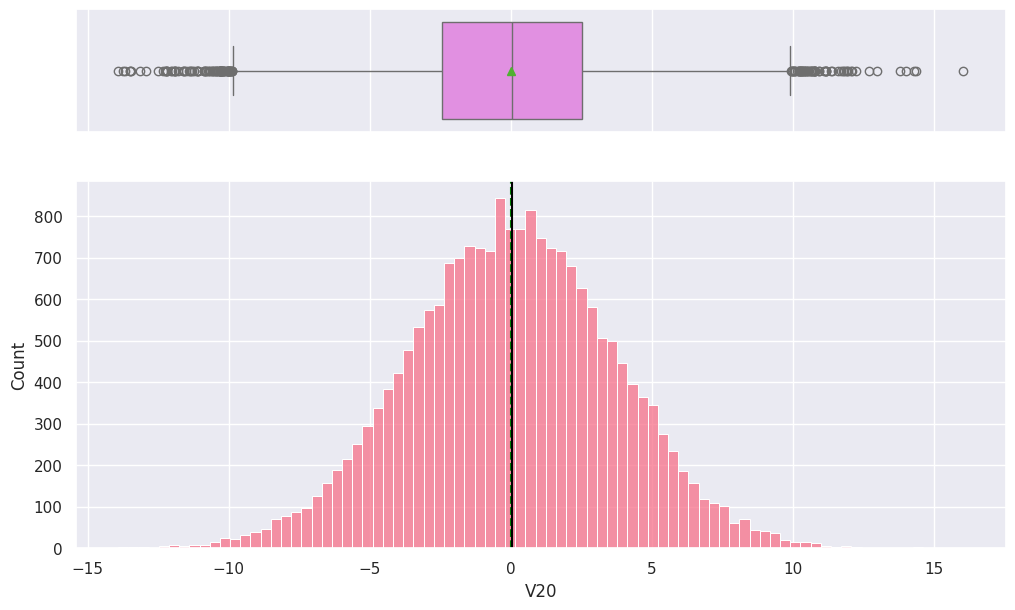

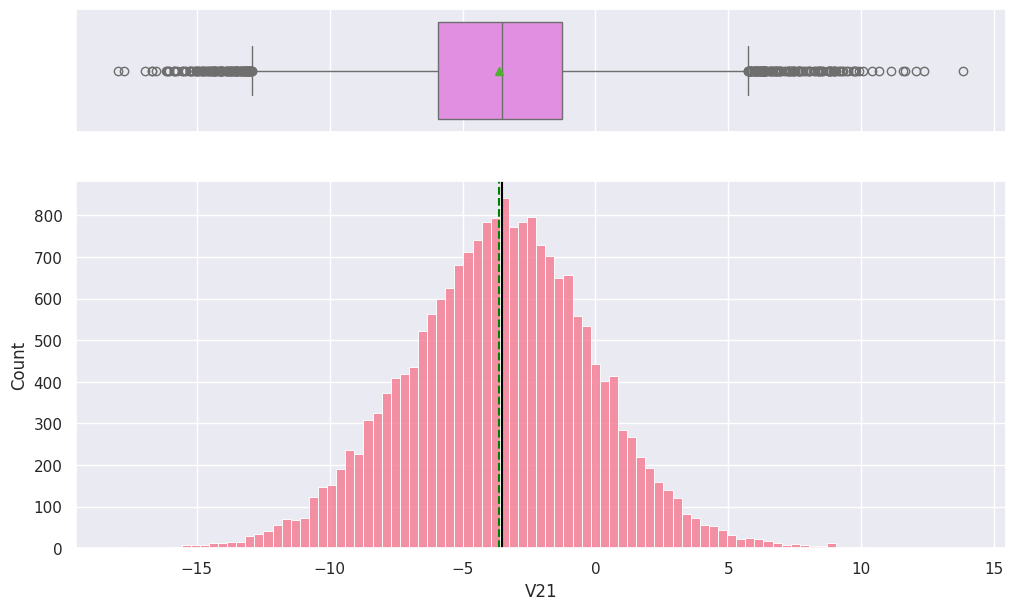

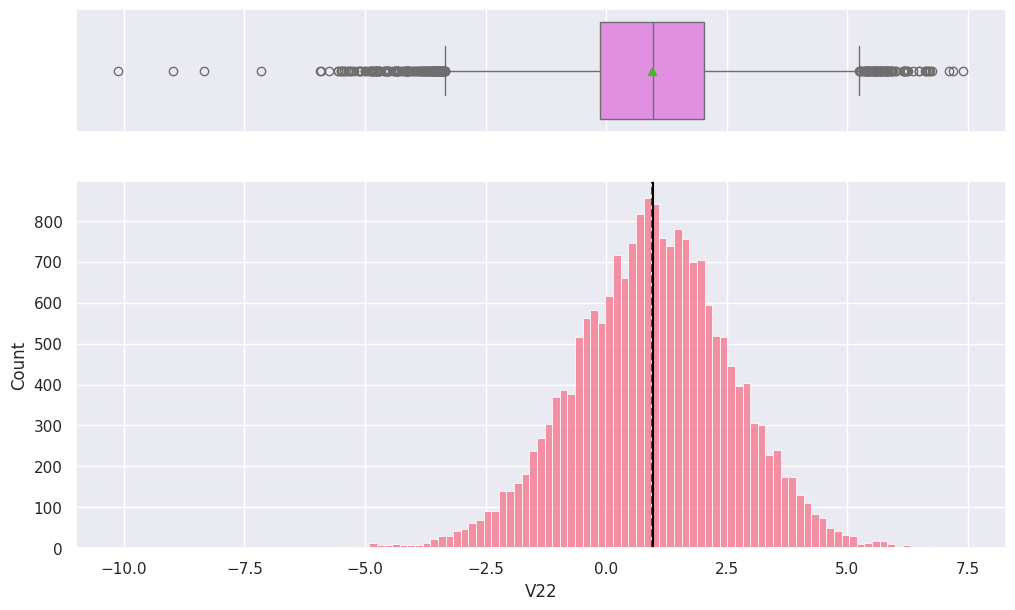

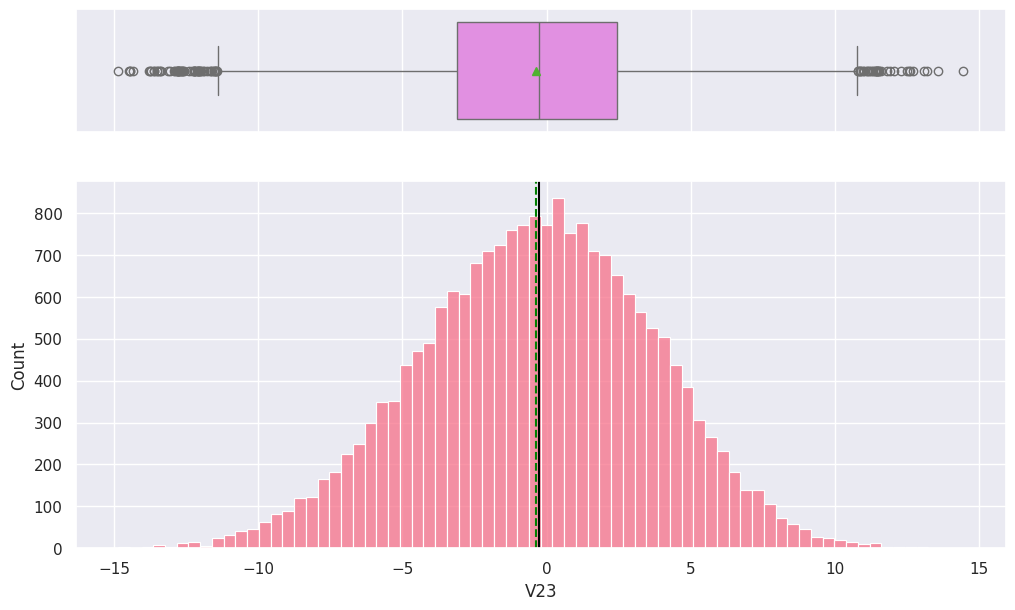

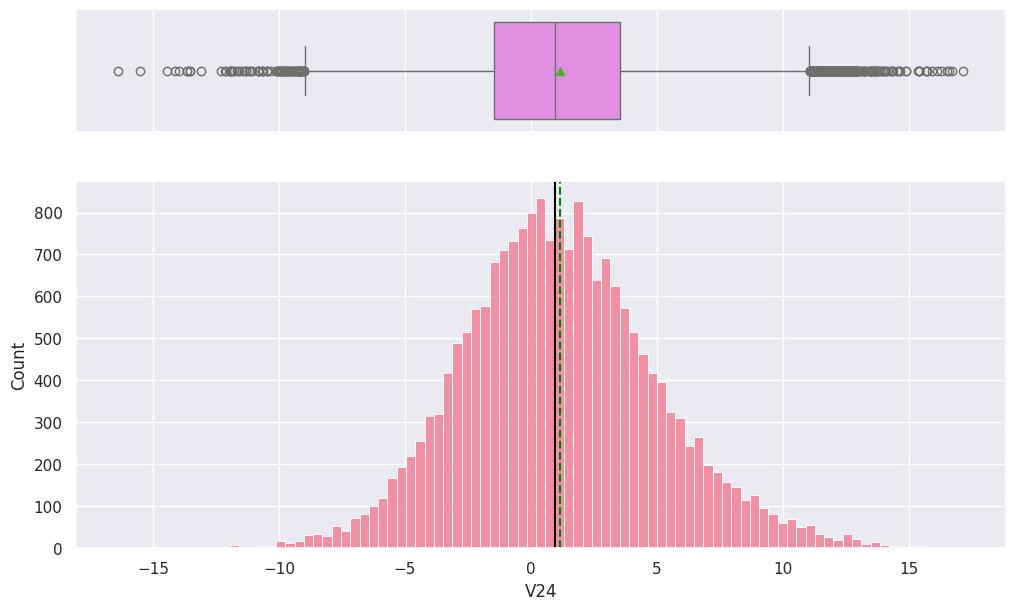

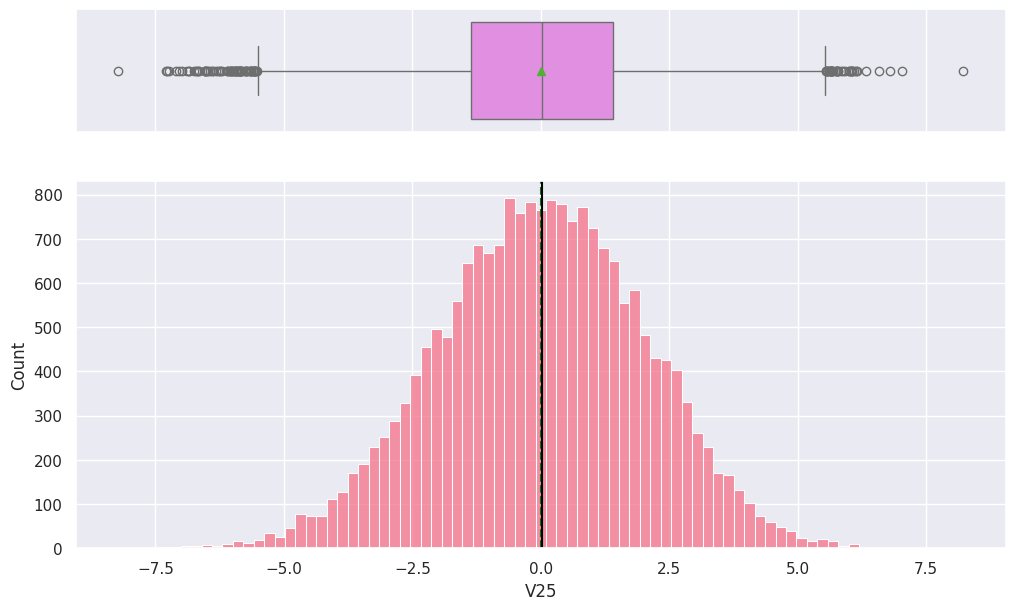

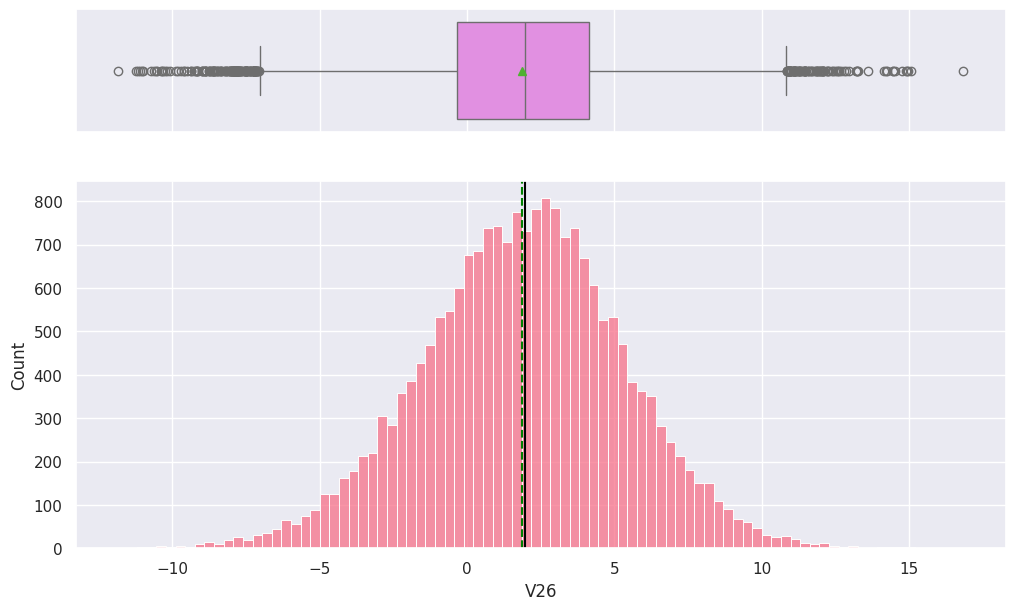

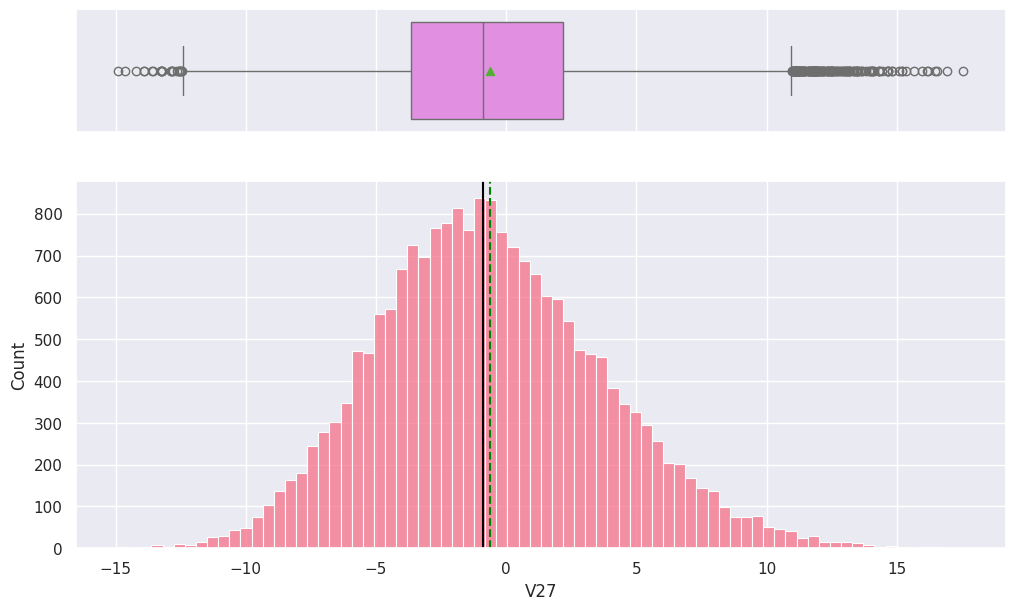

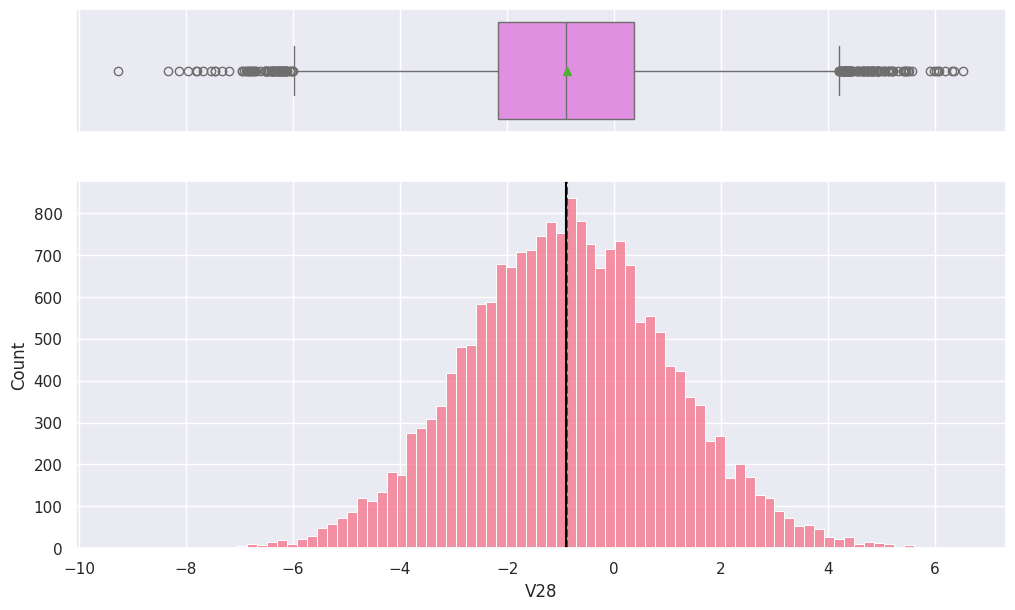

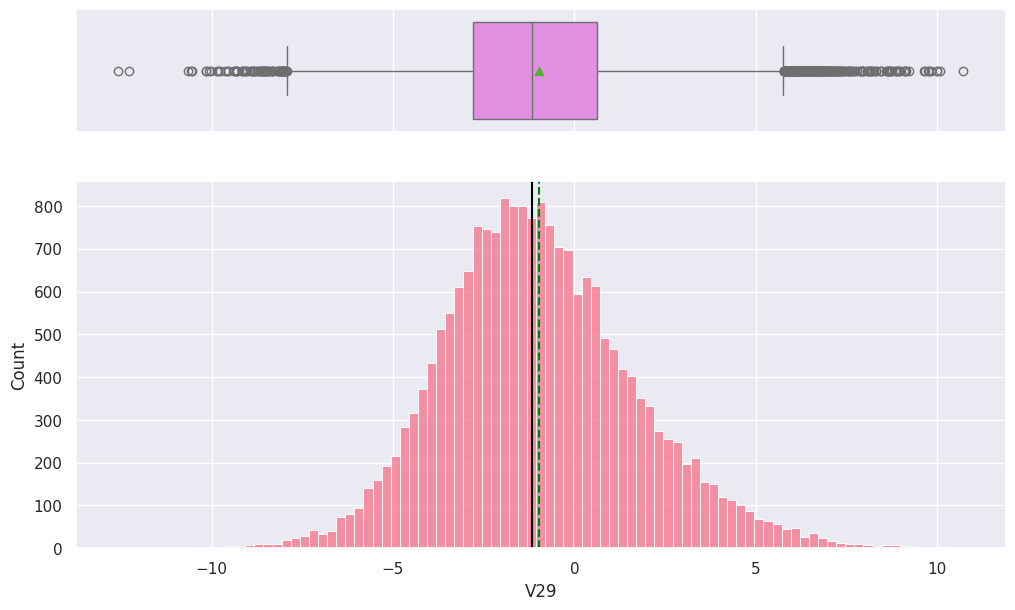

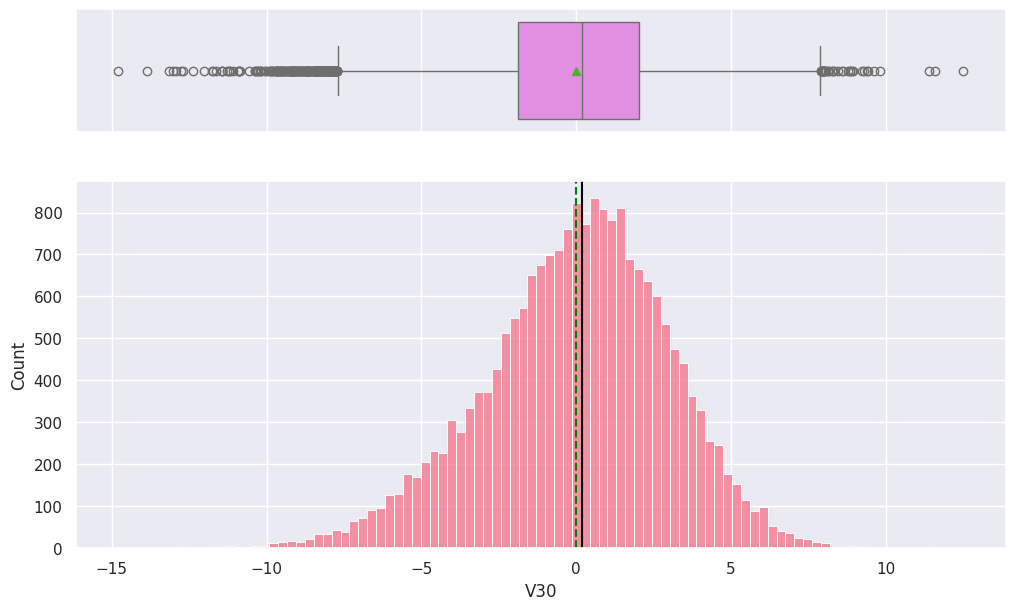

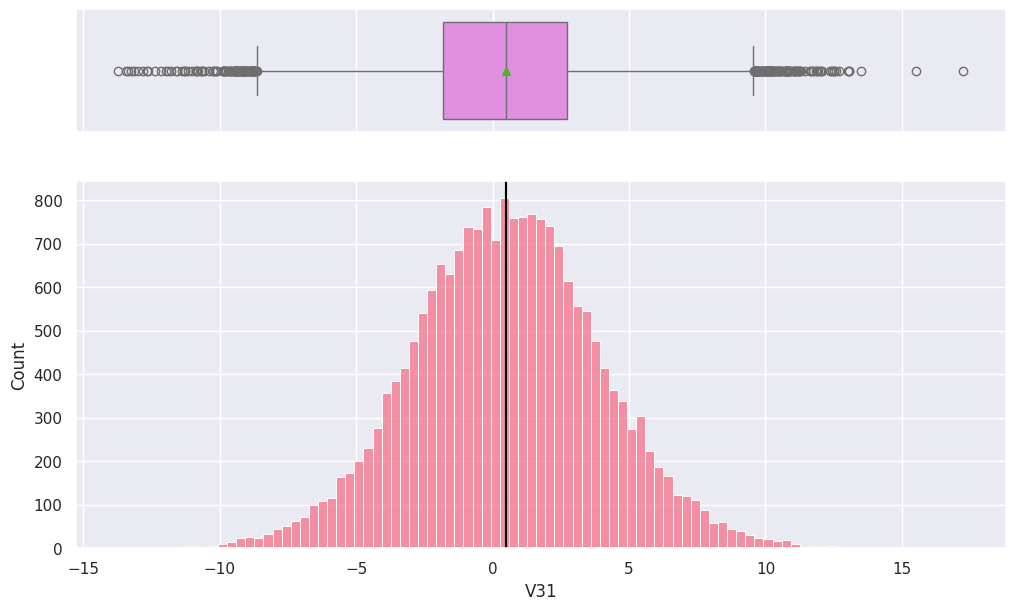

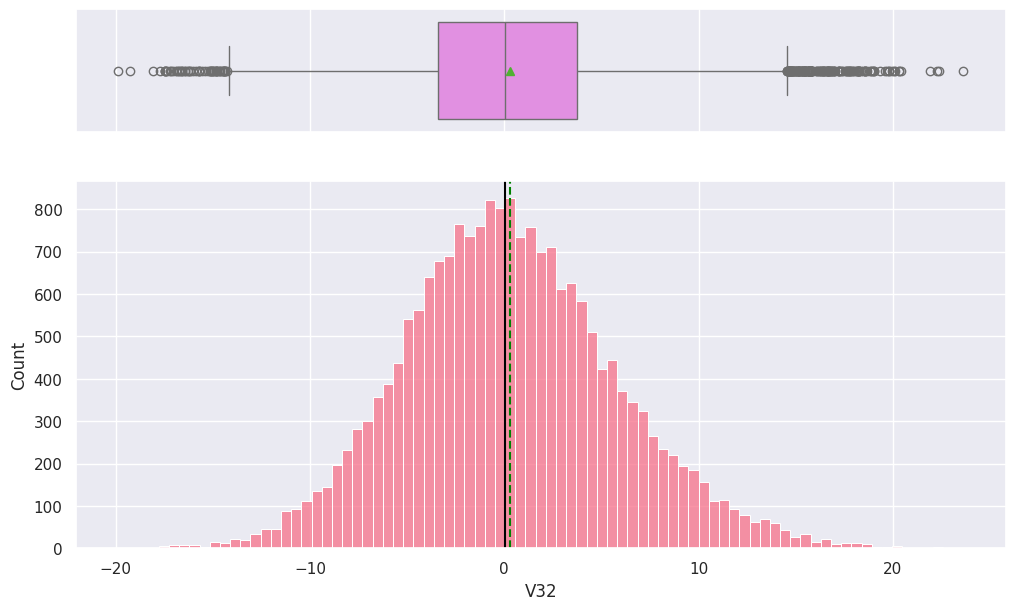

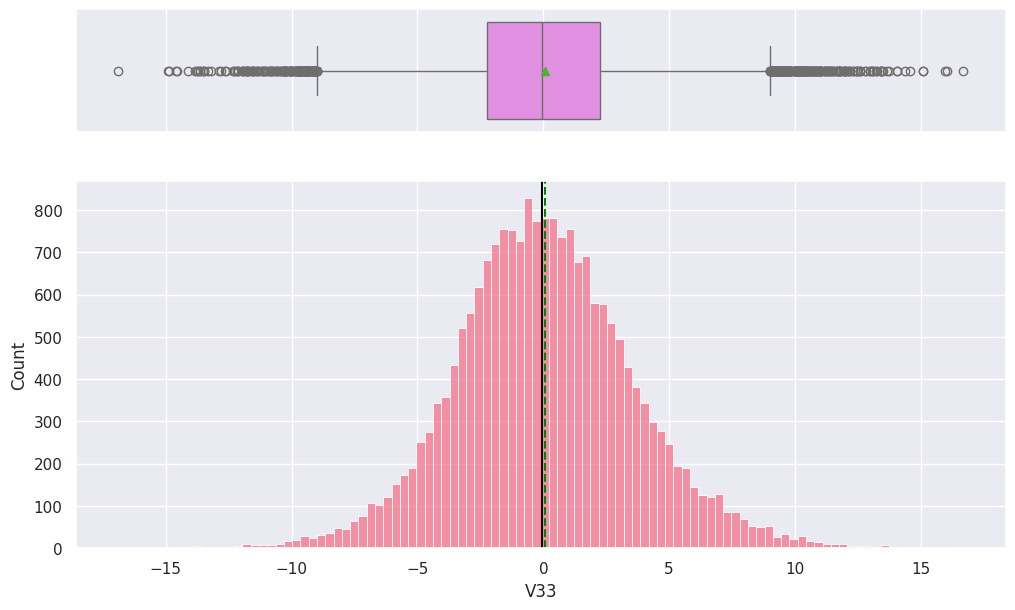

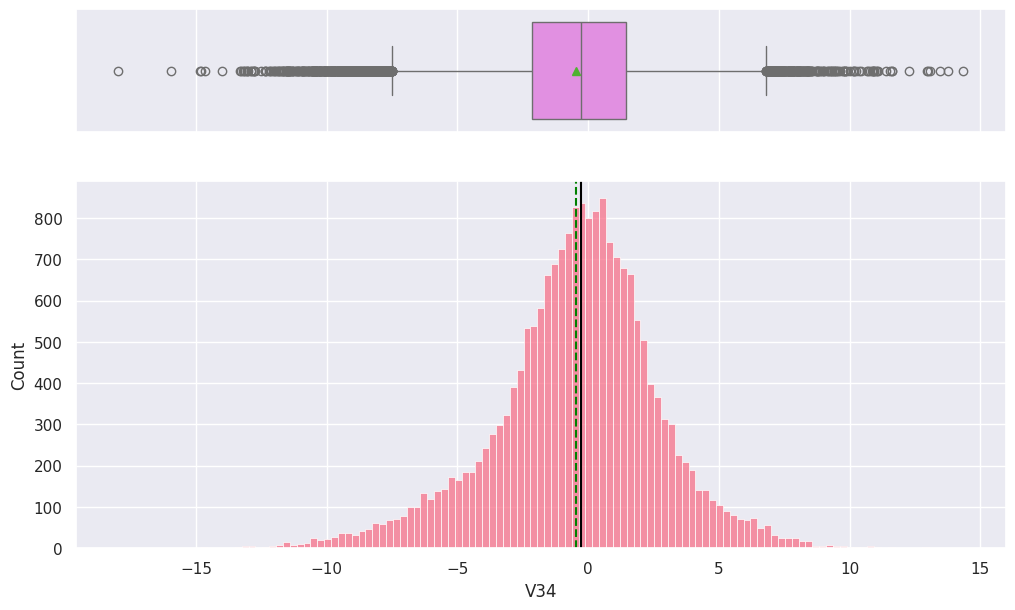

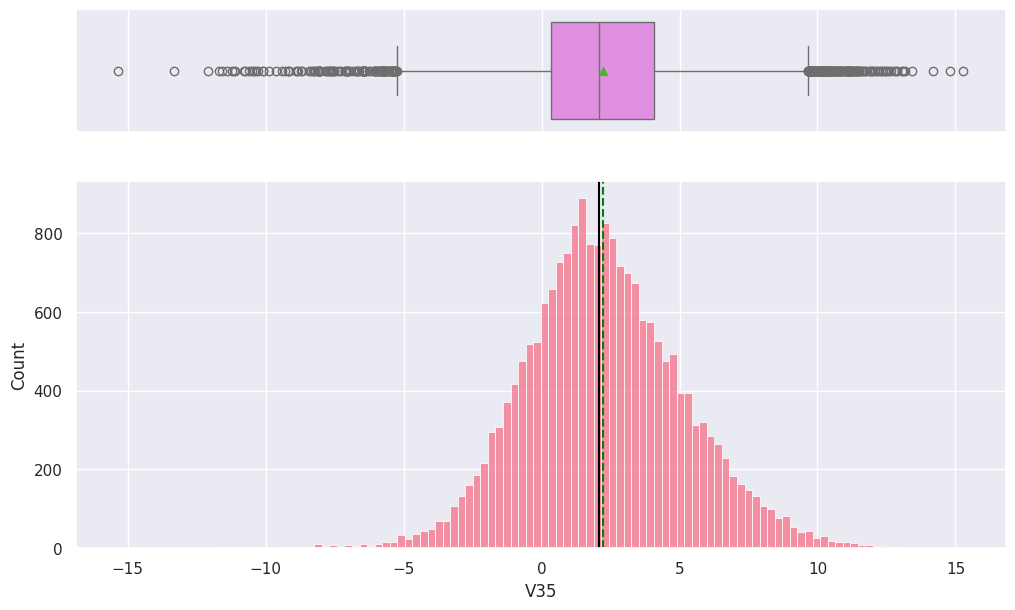

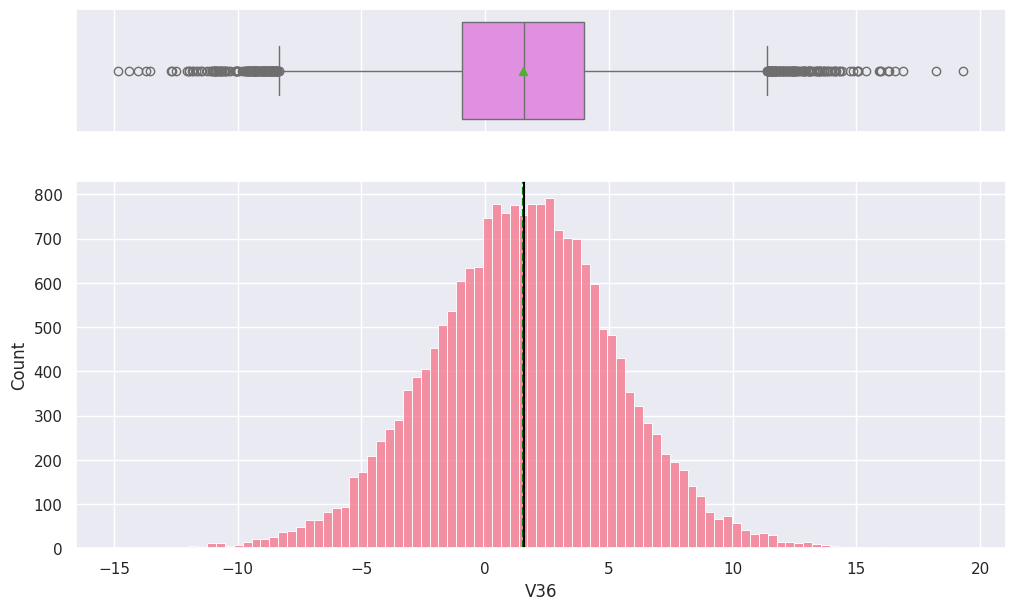

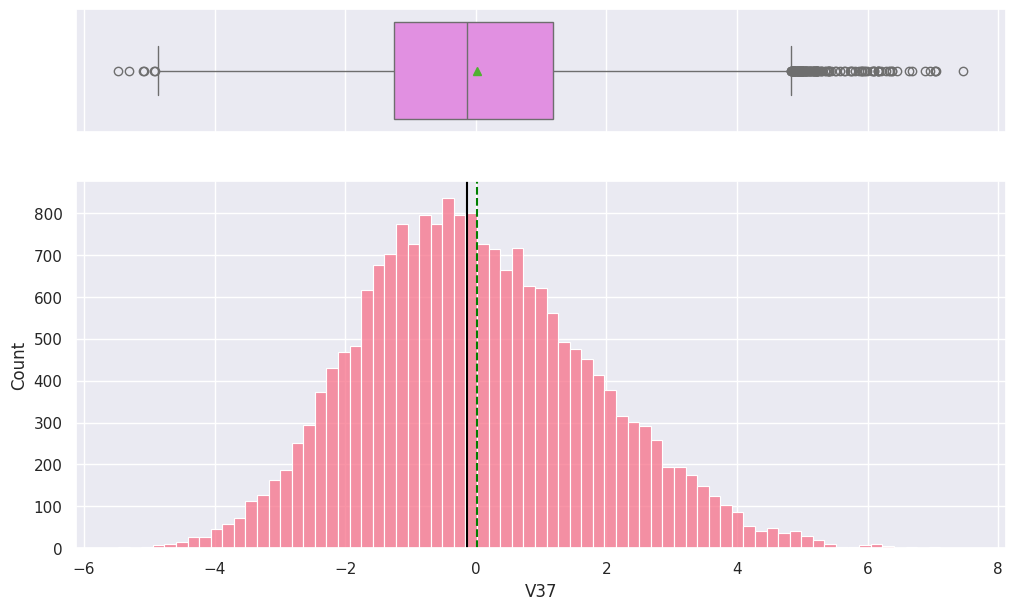

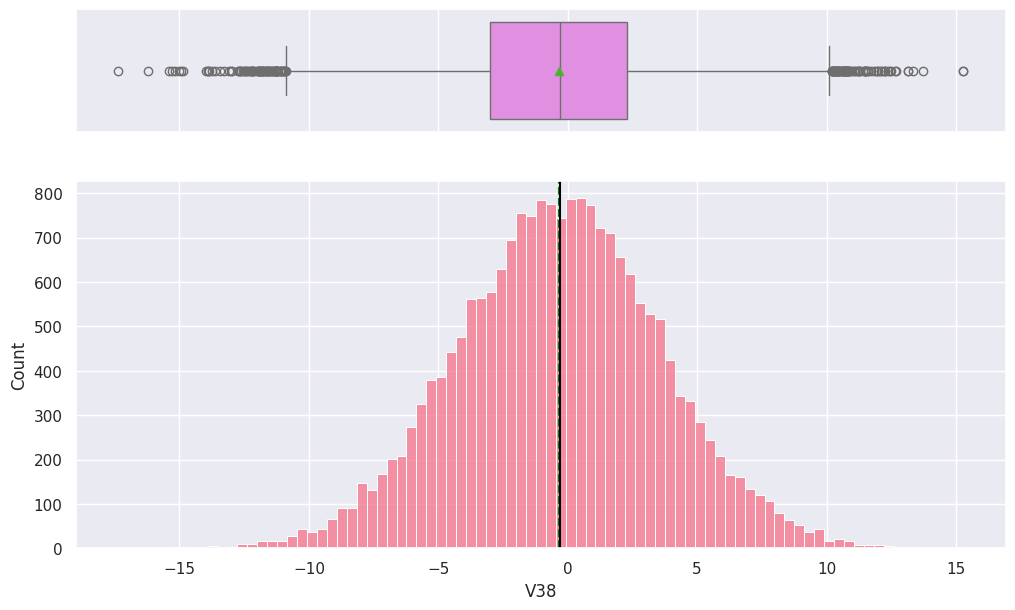

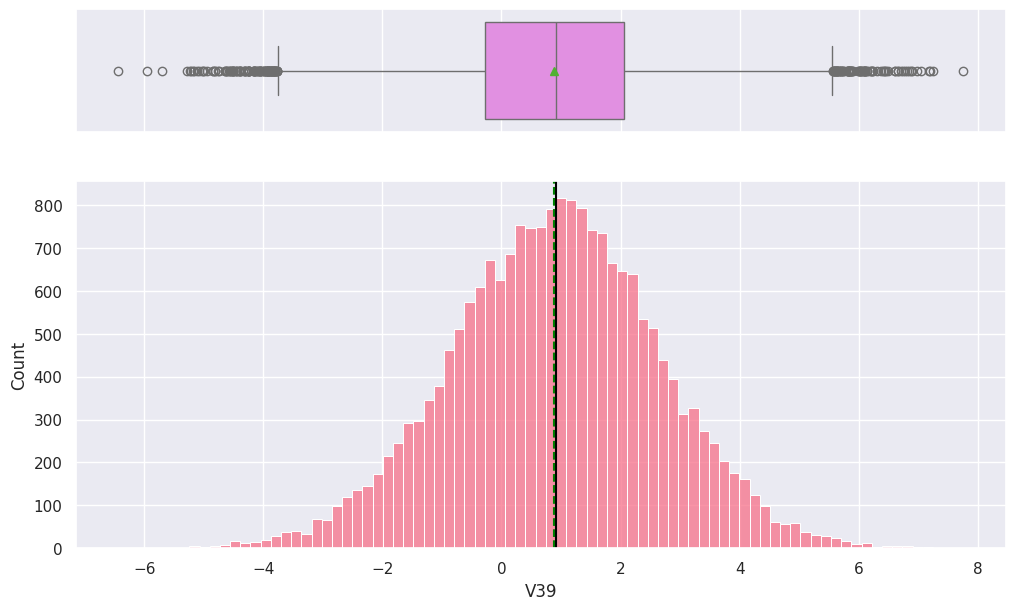

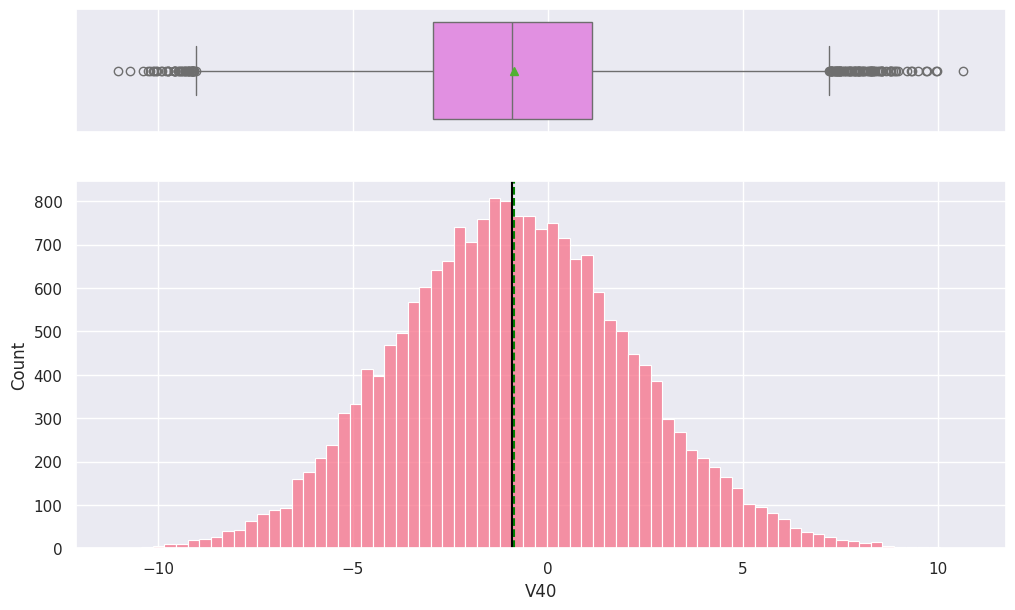

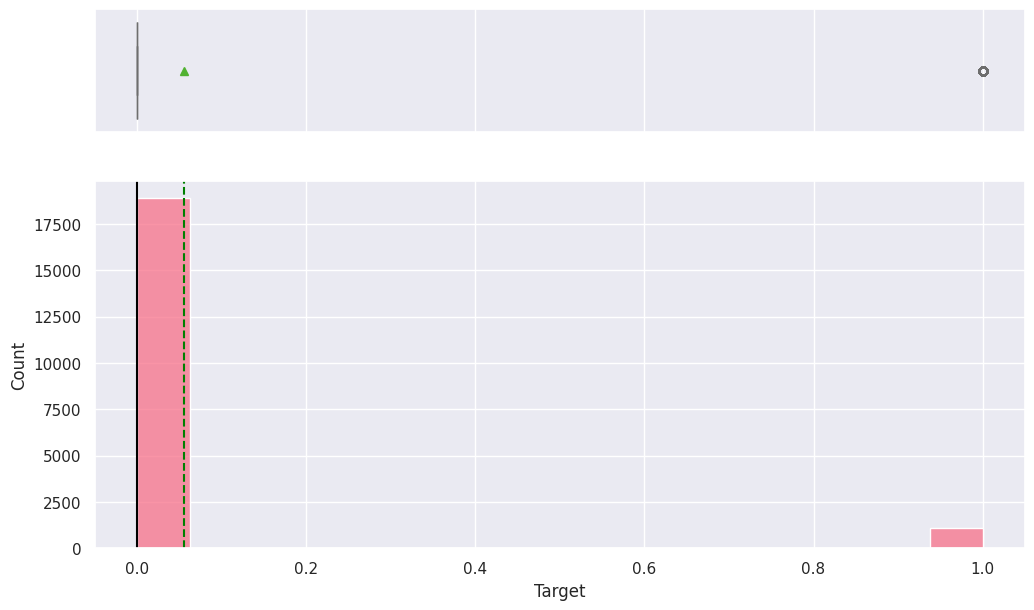

In [ ]:
for feature in df.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

**Observations:**

* Most of the feature columns are almost normally distributed
* There are outliers on both the sides for most of the feature variables
* The distribution of target variable is highly imbalanced

### Bivariate analysis

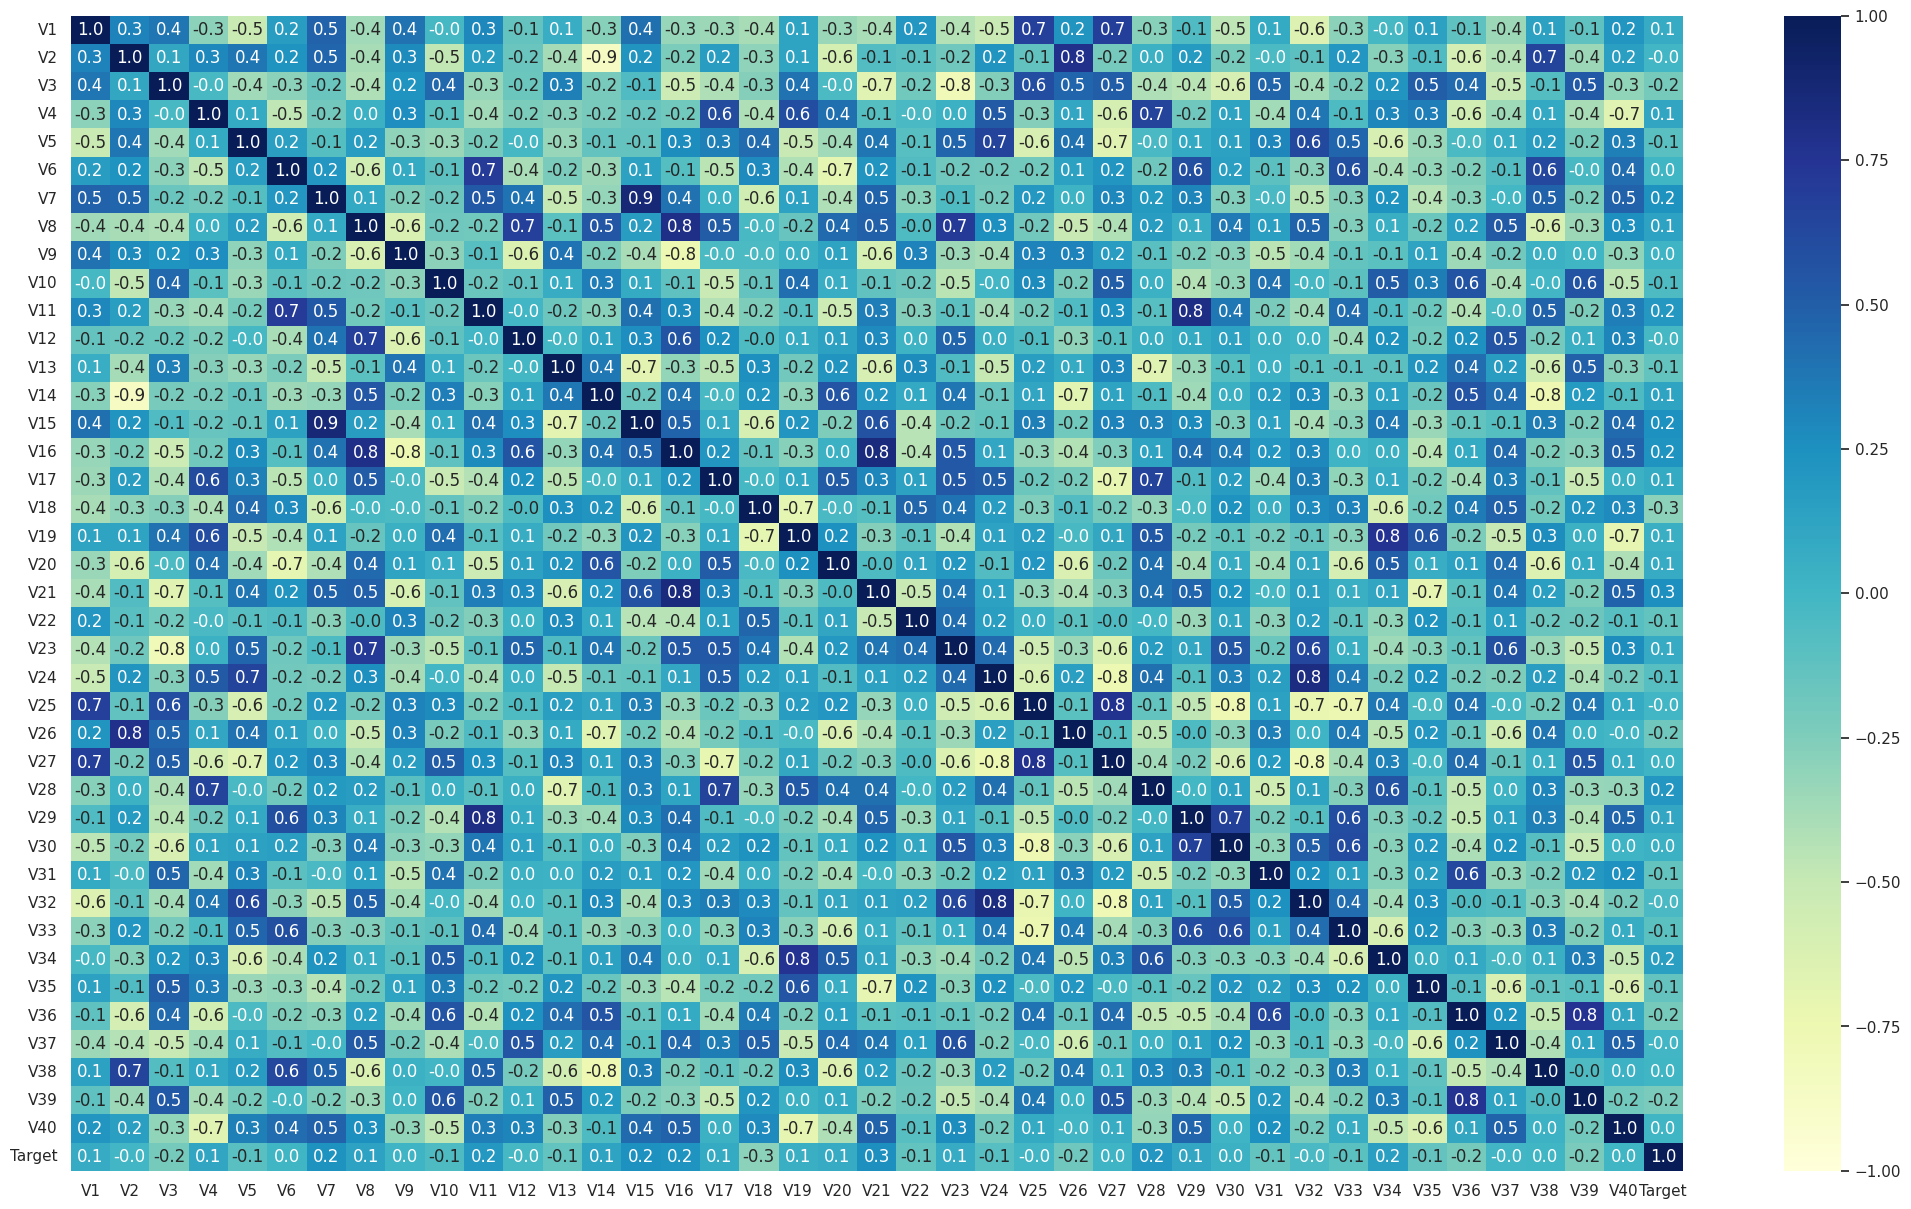

In [ ]:
# Lets plot the correlation of the fatrure vaiables using a heatmap
cols_list = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(26, 15))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".1f", cmap="YlGnBu"
)
plt.show()


* There are several features showing some correlation with each other, indicating some sort of multi collinearity
* The target varaibale doesn't seem to have any strong corrrelation with any of the features. V18 and V21 are the couple of features came up with maximum -ve correlation with the target variable


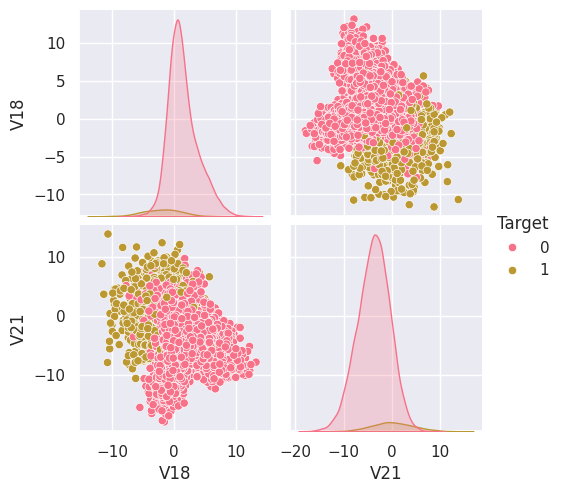

In [ ]:
# Selected a subset of features for the pair plot for better performance and clarity
selected_features = ['V18', 'V21', 'Target']
# Create the pair plot for the dataset
sns.pairplot(data[selected_features], hue='Target', diag_kind='kde')
plt.show()

### Let's look at the values in target variable

In [ ]:
data["Target"].value_counts(normalize=True)

,proportion
Target,
0,0.945
1,0.056


In [ ]:
data_test["Target"].value_counts(normalize=True)

,proportion
Target,
0,0.944
1,0.056


* The target variable is suffering from a high degree of imbalance in both training and test data sets

## Data Pre-Processing

In [6]:
# Dividing train data into X and y
X = data.drop(["Target"], axis=1)
y = data["Target"]

**Since we already have a separate test set, we don't need to divide data into train, valiation and test**


*to avoid any data leakage, we will first split the dataset in the training file to train and validation.*

In [7]:
# Splitting train dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y)

# Checking the number of rows and columns in the X_train data and X_val data
print(X_train.shape, X_val.shape)

(15000, 40) (5000, 40)


In [8]:
# Dividing test data into X_test and y_test

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [9]:
# Checking the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

## Missing value imputation




In [10]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

- To avoid data leakage, we compute the value to impute by from the training set, and then use that value for imputing missing values in the validation and test sets.
- To compute the value to impute with and fill the missing values, we use the `fit_transform()` function.
- To only fill the missing values, we use the `transform()` function.

In [11]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [12]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)

print(X_val.isna().sum())
print("-" * 30)

print(X_test.isna().sum())
print("-" * 30)

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

* we will leave the outliers as they may have a significance in terms of the sensor readings

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [13]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [14]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

# Cross-validation across all models
for name, model in models:
    # StratifiedKFold setup
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

# Fit models on the original training set and evaluate on the original validation set
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
Logistic Regression: 0.4927566553639709
GBM: 0.7066661857008874
Adaboost: 0.5371329629896833
Xgboost: 0.8100497799581561

Validation Performance:

dtree: 0.7050359712230215
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
Logistic Regression: 0.4856115107913669
GBM: 0.7230215827338129
Adaboost: 0.6007194244604317
Xgboost: 0.8309352517985612


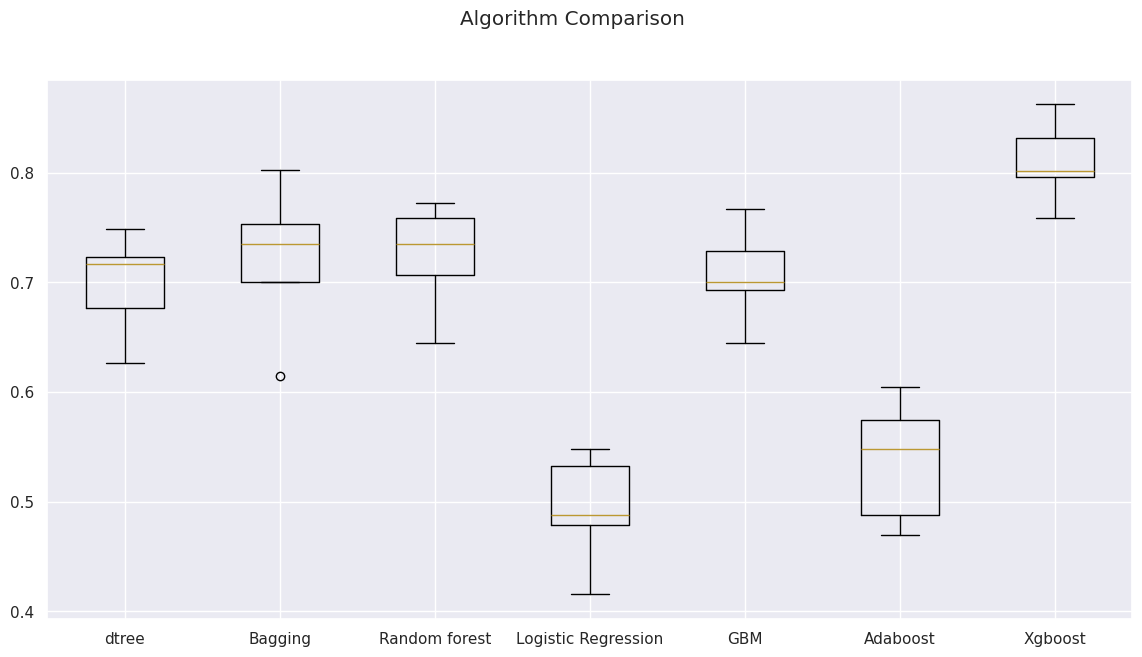

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(14, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

* XGBoost is giving the highest cross-validated recall score followed by  Random Forest and bagging classifier

*Lets build the same 7 models with oversampled data and check the performance scores.*

### Model Building with Oversampled data


In [15]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Logistic Regression", LogisticRegression(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
Logistic Regression: 0.883963699328486
GBM: 0.9256068151319724
Adaboost: 0.891445687121811
Xgboost: 0.9891305241357218

Validation Performance:

dtree: 0.7769784172661871
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
Logistic Regression: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8597122302158273
Xgboost: 0.8669064748201439


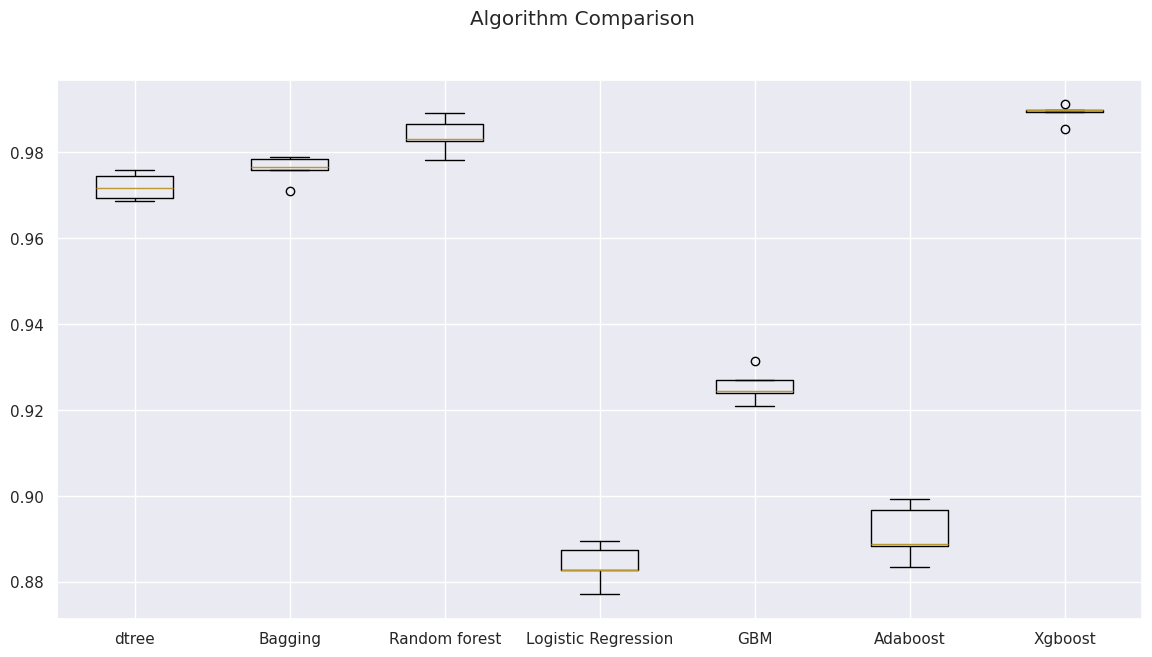

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(14,7))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names_over)

plt.show()

* XGBoost is giving the best cross-validated recall followed by Random Forest and Bagging.
* There is a significant reduction in performance for almost all models when run on validation set

*Lets try undersampling with these models now*

### Model Building with Undersampled data

In [16]:
print("Before Undersampling, counts of label 'Yes' : {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No' : {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of X_train: {}".format(X_train_under.shape))
print("After Undersampling, the shape of y_train: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes' : 832
Before Undersampling, counts of label 'No' : 14168 

After Undersampling, counts of label 'Yes': 832
After Undersampling, counts of label 'No': 832 

After Undersampling, the shape of X_train: (1664, 40)
After Undersampling, the shape of y_train: (1664,) 



In [ ]:
models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("Logistic Regression", LogisticRegression(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_under = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
Logistic Regression: 0.8726138085275232
GBM: 0.8978572974532861
Adaboost: 0.8665969266286705
Xgboost: 0.9014717552846114

Validation Performance:

dtree: 0.841726618705036
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
Logistic Regression: 0.8525179856115108
GBM: 0.8884892086330936
Adaboost: 0.8633093525179856
Xgboost: 0.89568345323741


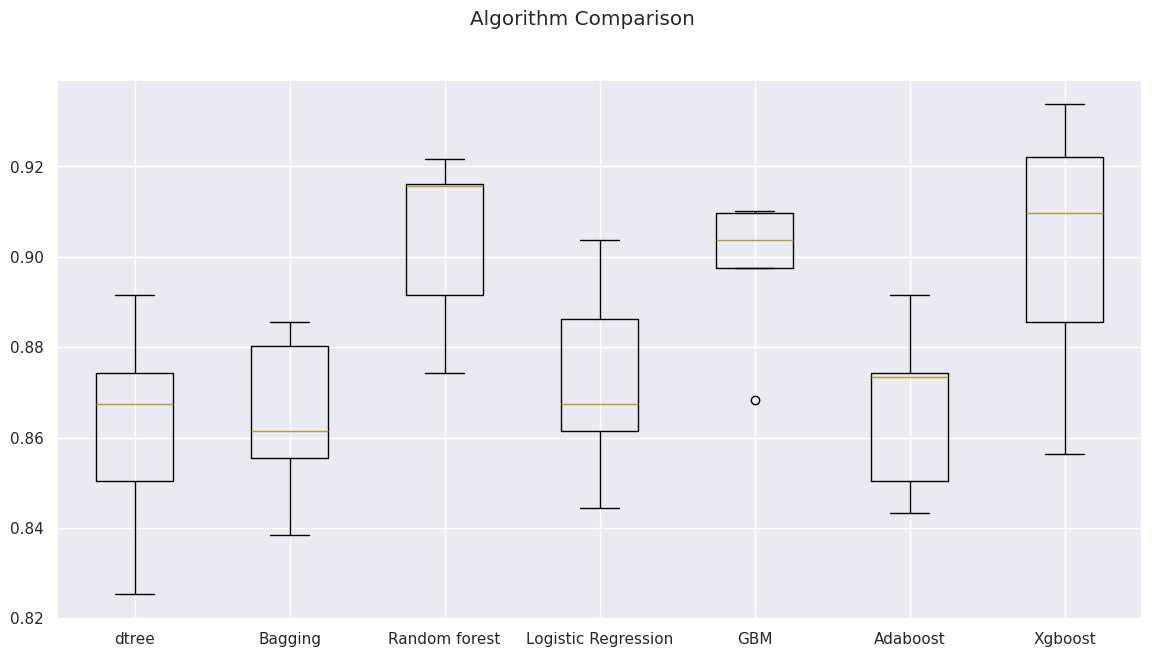

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(14,7))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results_under)
ax.set_xticklabels(names_under)

plt.show()

* Random Forest is giving the best cross-validated recall. Followed by XGBoost and Gradient Boosting.

## HyperparameterTuning

* After revieweing the performance of above models from original, oversampled and undersmapled executions above - we would pickup the below models for hyperparameter tuning


1.   XGBoost, Random Forest,Bagging classifier and Adaboost with oversampled data
3.   XGBoost, Random Forest and Gradient Boosting with undersampled data

we will also use RandomizedSearchCV as it is computationally less expensive choosing the n_iter variable optimally based on the number of parameters used

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning XGBoost using oversampled data

In [17]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1, eval_metric="logloss")

# Grid of parameters to choose from
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)


# Run the grid search
grid_obj = RandomizedSearchCV(estimator=xgb_tuned, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1, n_jobs = -1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
xgb_over_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_over_tuned.fit(X_train_over, y_train_over)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9959769935987322:


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [18]:
# Calculating metrics on train set
xgb_over_tuned_model_train_perf = model_performance_classification_sklearn(
    xgb_over_tuned, X_train_over, y_train_over
)
xgb_over_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [19]:
# Calculating metrics on validation set
xgb_over_tuned_model_val_perf= model_performance_classification_sklearn(xgb_over_tuned, X_val, y_val)
xgb_over_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.985,0.871,0.855,0.863


### Tuning XGBoost using Undersampled data

In [20]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1, eval_metric="logloss")

# Grid of parameters to choose from
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)


# Run the grid search
grid_obj = RandomizedSearchCV(estimator=xgb_tuned, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)
grid_obj = grid_obj.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
xgb_under_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_under_tuned.fit(X_train_under, y_train_under)

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9290599523843879:


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [21]:
# Calculating metrics on train set
xgb_under_tuned_model_train_perf = model_performance_classification_sklearn(
    xgb_under_tuned, X_train_under, y_train_under
)
xgb_under_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.979,1.000,0.960,0.979


In [22]:
# Calculating metrics on validation set
xgb_under_tuned_model_val_perf= model_performance_classification_sklearn(xgb_under_tuned, X_val, y_val)
xgb_under_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.832,0.921,0.239,0.379


### Tuning Random Forest using oversampled data

In [23]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator=rf_tuned, param_distributions=
                              param_grid, scoring=scorer, cv=5, n_jobs = -1,
                              n_iter=40, random_state=1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)


print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
rf_over_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_over_tuned.fit(X_train_over, y_train_over)

Best parameters are {'n_estimators': 200, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'} with CV score=0.9818606498020482:


RandomForestClassifier(max_samples=np.float64(0.6),
                       min_samples_leaf=np.int64(1), n_estimators=200,
                       random_state=1)

In [24]:
# Calculating metrics on train set
rf_over_tuned_model_train_perf= model_performance_classification_sklearn(rf_over_tuned, X_train_over, y_train_over)
rf_over_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,0.999,1.000,1.000


In [25]:
# Calculating metrics on validation set
rf_over_tuned_model_val_perf= model_performance_classification_sklearn(rf_over_tuned, X_val, y_val)
rf_over_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.988,0.863,0.920,0.891


### Tuning Random Forest using Undersampled data

In [26]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator=rf_tuned, param_distributions=
                              param_grid, scoring=scorer, cv=5, n_jobs = -1,
                              n_iter=40, random_state=1)
grid_obj = grid_obj.fit(X_train_under, y_train_under)


print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
rf_under_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_under_tuned.fit(X_train_under, y_train_under)

Best parameters are {'n_estimators': 300, 'min_samples_leaf': np.int64(2), 'max_samples': np.float64(0.5), 'max_features': 'sqrt'} with CV score=0.8990116153235697:


RandomForestClassifier(max_samples=np.float64(0.5),
                       min_samples_leaf=np.int64(2), n_estimators=300,
                       random_state=1)

In [27]:
# Calculating metrics on train set
rf_under_tuned_model_train_perf= model_performance_classification_sklearn(rf_under_tuned, X_train_under, y_train_under)
rf_under_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [28]:
# Calculating metrics on validation set
rf_under_tuned_model_val_perf= model_performance_classification_sklearn(rf_under_tuned, X_val, y_val)
rf_under_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


### Tuning Bagging Classifier using oversampled data

In [30]:
# Choose the type of classifier.
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 'max_features': [0.7,0.8,0.9], 'n_estimators' : [30,50,70], }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(bagging_estimator_tuned, param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
bagging_estimator_over_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_over_tuned.fit(X_train_over, y_train_over)

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9828488269988673:


BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70,
                  random_state=1)

In [31]:
# Calculating metrics on train set
bagging_estimator_tuned_over_model_train_perf = model_performance_classification_sklearn(
    bagging_estimator_over_tuned, X_train_over, y_train_over)
bagging_estimator_tuned_over_model_train_perf

,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [32]:
# Calculating metrics on validation set
bagging_estimator_tuned_over_model_val_perf = model_performance_classification_sklearn(
    bagging_estimator_over_tuned, X_val, y_val)
bagging_estimator_tuned_over_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.986,0.867,0.883,0.875


### Tuning Gradient Boosting using Oversampled data

In [33]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25),
               "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator=gbc_tuned, param_distributions=param_grid,
                  n_iter=15, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
gbc_over_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_over_tuned.fit(X_train_over, y_train_over)


Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(125), 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9726854410951082:


GradientBoostingClassifier(learning_rate=1, max_features=0.5,
                           n_estimators=np.int64(125), random_state=1,
                           subsample=0.7)

In [34]:
# Calculating metrics on train set
gbc_over_tuned_model_train_perf= model_performance_classification_sklearn(gbc_over_tuned, X_train_over, y_train_over)
gbc_over_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.993,0.993,0.994,0.993


In [35]:
# Calculating metrics on validation set
gbc_over_tuned_model_val_perf= model_performance_classification_sklearn(gbc_over_tuned, X_val, y_val)
gbc_over_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.971,0.845,0.693,0.762


### Tuning Gradient Boosting using Undersampled data

In [36]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": np.arange(100,150,25),
              "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7],
               "max_features":[0.5,0.7] }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(estimator=gbc_tuned, param_distributions=param_grid,
                  n_iter=15, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
grid_obj = grid_obj.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
gbc_under_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_under_tuned.fit(X_train_under, y_train_under)


Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(125), 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.903816463458625:


GradientBoostingClassifier(learning_rate=0.2, max_features=0.7,
                           n_estimators=np.int64(125), random_state=1,
                           subsample=0.7)

In [37]:
# Calculating metrics on train set
gbc_under_tuned_model_train_perf= model_performance_classification_sklearn(gbc_under_tuned, X_train_under, y_train_under)
gbc_under_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.995,0.990,0.999,0.995


In [38]:
# Calculating metrics on validation set
gbc_under_tuned_model_val_perf= model_performance_classification_sklearn(gbc_under_tuned, X_val, y_val)
gbc_under_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.927,0.885,0.423,0.573


### Tuning Adaboost using Oversampled data

In [39]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {
    "n_estimators": np.arange(50,110,25),
    "learning_rate": [0.2, 0.05],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = RandomizedSearchCV(abc_tuned, param_grid, n_jobs = -1, n_iter=10, scoring=scorer, cv=5, random_state=1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(grid_obj.best_params_,grid_obj.best_score_))

# Set the clf to the best combination of parameters
abc_over_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_over_tuned.fit(X_train_over, y_train_over)


Best parameters are {'n_estimators': np.int64(100), 'learning_rate': 0.2, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9100793625685384:


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=0.2, n_estimators=np.int64(100),
                   random_state=1)

In [40]:
# Calculating metrics on train set
abc_over_tuned_model_train_perf= model_performance_classification_sklearn(abc_over_tuned, X_train_over, y_train_over)
abc_over_tuned_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.936,0.912,0.958,0.934


In [41]:
# Calculating metrics on validation set
abc_over_tuned_model_val_perf= model_performance_classification_sklearn(abc_over_tuned, X_val, y_val)
abc_over_tuned_model_val_perf

,Accuracy,Recall,Precision,F1
0,0.946,0.878,0.510,0.646


## Model performance comparison and choosing the final model

In [42]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
      xgb_over_tuned_model_train_perf.T,
      xgb_under_tuned_model_train_perf.T,
      rf_over_tuned_model_train_perf.T,
      rf_under_tuned_model_train_perf.T,
      bagging_estimator_tuned_over_model_train_perf.T,
      gbc_over_tuned_model_train_perf.T,
      gbc_under_tuned_model_train_perf.T,
      abc_over_tuned_model_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with undersampled data",
    "Random forest tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Bagging classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "AdaBoost classifier tuned with oversampled data"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost tuned with oversampled data,XGBoost tuned with undersampled data,Random forest tuned with oversampled data,Random forest tuned with undersampled data,Bagging classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,Gradient Boosting tuned with undersampled data,AdaBoost classifier tuned with oversampled data
Accuracy,1.000,0.979,1.000,0.961,1.000,0.993,0.995,0.936
Recall,1.000,1.000,0.999,0.933,1.000,0.993,0.990,0.912
Precision,1.000,0.960,1.000,0.989,1.000,0.994,0.999,0.958
F1,1.000,0.979,1.000,0.960,1.000,0.993,0.995,0.934


In [43]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
      xgb_over_tuned_model_val_perf.T,
      xgb_under_tuned_model_val_perf.T,
      rf_over_tuned_model_val_perf.T,
      rf_under_tuned_model_val_perf.T,
      bagging_estimator_tuned_over_model_val_perf.T,
      gbc_over_tuned_model_val_perf.T,
      gbc_under_tuned_model_val_perf.T,
      abc_over_tuned_model_val_perf.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost tuned with oversampled data",
    "XGBoost tuned with undersampled data",
    "Random forest tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Bagging classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "Gradient Boosting tuned with undersampled data",
    "AdaBoost classifier tuned with oversampled data"
]
print("Training performance comparison:")
models_val_comp_df


Training performance comparison:


,XGBoost tuned with oversampled data,XGBoost tuned with undersampled data,Random forest tuned with oversampled data,Random forest tuned with undersampled data,Bagging classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,Gradient Boosting tuned with undersampled data,AdaBoost classifier tuned with oversampled data
Accuracy,0.985,0.832,0.988,0.938,0.986,0.971,0.927,0.946
Recall,0.871,0.921,0.863,0.885,0.867,0.845,0.885,0.878
Precision,0.855,0.239,0.920,0.468,0.883,0.693,0.423,0.510
F1,0.863,0.379,0.891,0.612,0.875,0.762,0.573,0.646


* Most of the models above appears to be overfitting and the ones returned good score for Recall found to be underfitting for the other parameters.
* Considering all the above and to bring everything to a balance towards generalization, lets pick up *Adaboost classifer tuned with oversampled data* as outr final model and run that through the test data.

### Test set final performance

In [44]:
# Check the performance of the final model on the test data
ada_test_scores = model_performance_classification_sklearn(abc_over_tuned, X_test, y_test)
ada_test_scores

,Accuracy,Recall,Precision,F1
0,0.946,0.848,0.513,0.639


### Feature Importances

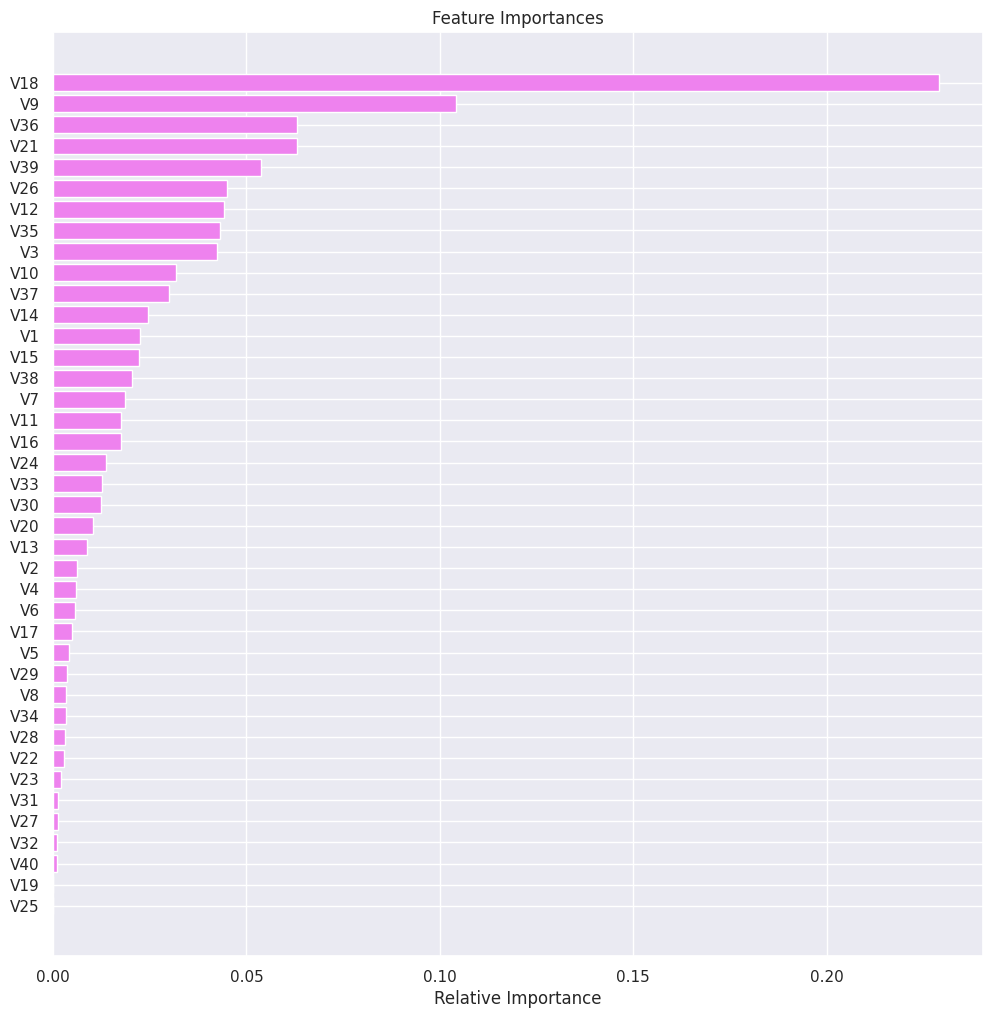

In [45]:
feature_names = X_train.columns
importances =  abc_over_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* V18 is the most important feature.
* Other features with similar importance are V9,V36 and V21.

## Pipelines to build the final model


- Since we have only one datatype in the data, we don't need to use column transformer here

In [46]:
# Creating pipeline with best parameters
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("AdaBoost", AdaBoostClassifier
         (
               n_estimators= 100,
               learning_rate= 0.2,
               estimator= DecisionTreeClassifier(max_depth=3, random_state=1),
          ),
        )
    ]
)

pipe.steps

[('imputer', SimpleImputer(strategy='median')),
 ('AdaBoost',
  AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                      random_state=1),
                     learning_rate=0.2, n_estimators=100))]

In [47]:
# Splitting the train dataset into dependent and independent variables
X_pipe = df.drop(['Target'], axis=1)
Y_pipe = df['Target']

In [48]:
# Splitting the test data into X and Y variables
X_test_pipe = df_test.drop(['Target'], axis=1)
Y_test_pipe = df_test['Target']

In [49]:
# Imputting missing values before Oversampling data
imputer = SimpleImputer(strategy='median')

# Fit and transform the train data
X_pipe = imputer.fit_transform(X_pipe)

In [50]:
# Oversampling data on training set
ada_over = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_pipe_over, Y_pipe_over = ada_over.fit_resample(X_pipe, Y_pipe)

In [51]:
# Fitting the model on training data
pipe.fit(X_pipe_over, Y_pipe_over)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('AdaBoost',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                                     random_state=1),
                                    learning_rate=0.2, n_estimators=100))])

In [52]:
# Checking performance on test set
pipe_test = model_performance_classification_sklearn(pipe, X_test_pipe, Y_test_pipe)
print("Final Model performance on Test Dataset:")
pipe_test

Final Model performance on Test Dataset:


,Accuracy,Recall,Precision,F1
0,0.946,0.844,0.511,0.636


# Business Insights and Conclusions

* The final model above is giving a recall score of 0.84 and should be able to  to predict most generator failures.
* Accuracy score with this model is good and generalizes well on data.
* Precision score is low with ~0.51, which will result in generator inspections due to high false positives.

* *The model chosen here is based on the best available and may not be the best for the precition until this is productionized and evaluated.*
* The company should still look for providing more data to the Data Science team, to keep trying to find a more generalized model that fits the ppurpose.
* There should be some mechanism for continuously evaluating and tuning the performances



* V18,V9,V36,V21 and V39 came up as the top features in terms of importance. The company should pay more attention to these sensors during their periodic maintenance.
* The company should also devise some mechanism to keep monitoring the patterns of failures on the above sensors and the model predictions

***